# Pipeline for High-z Radio Galaxies 06: Application of full pipeline for prediction with optimised thresholds

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage import gaussian_filter
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import sklearn.pipeline
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
import pandas as pd
import mpl_scatter_density
from joblib import dump, load
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

Functions to predict values

In [4]:
def predict_star(catalog_df, star_model, cal_str_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(star_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_1'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    catalog_df.loc[:, 'Score_no_star'] = np.around(catalog_df.loc[:, 'Score_no_star'], decimals=7)
    pred_probs = cal_str_model.predict(catalog_df.loc[:, 'Score_0'])
    cal_class  = np.array(pred_probs < (1 - cal_threshold)).astype(int)
    catalog_df['Prob_no_star']  = pred_probs
    catalog_df['pred_star_cal'] = cal_class
    return catalog_df

In [5]:
def predict_AGN_gal(catalog_df, AGN_gal_model, cal_AGN_gal_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(AGN_gal_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
    catalog_df.loc[:, 'Score_AGN'] = np.around(catalog_df.loc[:, 'Score_AGN'], decimals=7)
    pred_probs = cal_AGN_gal_model.predict(catalog_df.loc[:, 'Score_AGN'])
    cal_class  = np.array(pred_probs >= cal_threshold).astype(int)
    catalog_df['Prob_AGN']       = pred_probs
    catalog_df['pred_class_cal'] = cal_class
    return catalog_df

In [6]:
def predict_radio_det(catalog_df, radio_model, cal_radio_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(radio_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
    catalog_df.loc[:, 'Score_radio'] = np.around(catalog_df.loc[:, 'Score_radio'], decimals=7)
    pred_probs = cal_radio_model.predict(catalog_df.loc[:, 'Score_radio'])
    cal_class  = np.array(pred_probs >= cal_threshold).astype(int)
    catalog_df['Prob_radio']     = pred_probs
    catalog_df['pred_radio_cal'] = cal_class
    return catalog_df

In [7]:
def predict_z_full(catalog_df, redshift_model):
    catalog_df = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    catalog_df = catalog_df.rename(columns={'Label': 'pred_Z'})
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=4)
    return catalog_df

In [8]:
def predict_z_high(catalog_df, redshift_model, z_lim, z_tol):
    catalog_df    = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    filter_pred_z = catalog_df.loc[:, 'pred_Z'] >= (z_lim + z_tol)
    catalog_df.loc[:, 'pred_Z'] = catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, catalog_df.loc[filter_pred_z, 'Label'])
    catalog_df    = catalog_df.drop(columns=['Label'])
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=4)
    return catalog_df

In [9]:
def M12_AGN_criterion(catalog_df):
    M12_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 <
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 0.791) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 0.222) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           -3.172 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 7.624)).astype(int)
    return M12_column

In [10]:
def S12_AGN_criterion(catalog_df):
    S12_column = np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >= 0.8).astype(int)
    return S12_column

In [11]:
def M16_AGN_criterion(catalog_df):
    M16_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 < 4.4)).astype(int)
    return M16_column

In [12]:
def B18_AGN_criterion(catalog_df):
    B18_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 > 2.2) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           2 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 8.9)).astype(int)
    return B18_column

In [13]:
def C22_AGN_criterion(catalog_df):  # This work
    # C22_column = (np.array(catalog_df.loc[:, 'rmag'] - catalog_df.loc[:, 'zmag'] - 0.617 + 0.866 > -0.45) &
    #               np.array(catalog_df.loc[:, 'rmag'] - catalog_df.loc[:, 'zmag'] - 0.617 + 0.866 < 1.8) &
    #               np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
    #                        0.355 * (catalog_df.loc[:, 'rmag'] - catalog_df.loc[:, 'zmag'] - 0.617 + 0.866) + 0.26)).astype(int)  # W1-W2, r-z
    C22_column = (np.array(catalog_df.loc[:, 'gmag'] - catalog_df.loc[:, 'rmag'] - 0.481 + 0.617 > -0.76) &
                  np.array(catalog_df.loc[:, 'gmag'] - catalog_df.loc[:, 'rmag'] - 0.481 + 0.617 < 1.8) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           0.227 * (catalog_df.loc[:, 'rmag'] - catalog_df.loc[:, 'zmag'] - 0.481 + 0.617) + 0.43)).astype(int)  # W1-W2, g-r
    return C22_column

In [14]:
def add_AGN_criteria(catalog_df):
    catalog_df['M12_AGN'] = M12_AGN_criterion(catalog_df)
    catalog_df['S12_AGN'] = S12_AGN_criterion(catalog_df)
    catalog_df['M16_AGN'] = M16_AGN_criterion(catalog_df)
    catalog_df['B18_AGN'] = B18_AGN_criterion(catalog_df)
    catalog_df['C22_AGN'] = C22_AGN_criterion(catalog_df)
    return catalog_df

In [15]:
def radio_lum(flux, z, alpha):  # Output in W Hz-1
    lum_dist = cosmo.luminosity_distance(z).to(u.m)
    num      = 4 * np.pi * flux.to(u.Jy) * lum_dist**2
    denom    = (1 + z)**(alpha +1)
    return (num/denom).to(u.W / u.Hz)

In [16]:
def cut_rgb_val(val):
    if val < 0.0:
        return 0.0
    if val > 1.0:
        return 1.0
    else:
        return val

In [17]:
def fmt(x):
    x = x * 100.
    x = 100. - x
    s = f'{x:.2f}'
    if s.endswith('0'):
        s = f'{x:.0f}'
    return rf'{s} \%' if plt.rcParams['text.usetex'] else f'{s} %'

In [18]:
def make_borders_zero(matrix):
    matrix[:, 0]  = 0.0
    matrix[:, -1] = 0.0
    matrix[0, :]  = 0.0
    matrix[-1, :] = 0.0
    return matrix

In [19]:
def pad_matrix_zeros(matrix, xedges, yedges):  # Pads matrices and creates centred edges
    x_centres = 0.5 * (xedges[:-1] + xedges[1:])
    y_centres = 0.5 * (yedges[:-1] + yedges[1:])
    matrix    = np.pad(matrix, ((1, 1), (1, 1)), mode='constant', constant_values=(0,))
    x_centres = np.pad(x_centres, (1, 1), mode='constant', constant_values=(xedges[0], xedges[-1]))
    y_centres = np.pad(y_centres, (1, 1), mode='constant', constant_values=(yedges[0], yedges[-1]))
    return matrix, x_centres, y_centres

In [20]:
def clean_and_smooth_matrix(matrix, sigma=0.9):
    matrix[~np.isfinite(matrix)] = 0
    matrix_smooth = gaussian_filter(matrix, sigma=0.9)
    matrix_smooth[~np.isfinite(matrix_smooth)] = 0
    return matrix_smooth

In [21]:
colour_hex_rAGN        = '#D32F2F'
colour_cet_rAGN        = plt.get_cmap('cet_rainbow')(1.0)
colour_rAGN            = mcolors.to_rgba(colour_cet_rAGN)
colour_rAGN_rgb        = mcolors.to_rgb(colour_cet_rAGN)
colour_rAGN_shade      = list(colour_rAGN)
colour_rAGN_shade[3]   = 0.75
colour_rAGN_shade      = tuple(colour_rAGN_shade)
colour_rAGN_rgb_darker = list(colour_rAGN_rgb)
colour_rAGN_rgb_darker = list([value * 0.7 for value in colour_rAGN_rgb_darker])
colour_rAGN_rgb_bright = list([cut_rgb_val(value * 1.5) for value in list(colour_rAGN_rgb)])
colour_rAGN_rgb_darker = tuple(colour_rAGN_rgb_darker)
colour_rAGN_rgb_bright = tuple(colour_rAGN_rgb_bright)
colors_rAGN            = [colour_rAGN_rgb_darker, colour_rAGN_rgb_bright] # first color is darker
cm_gradient_rAGN       = mcolors.LinearSegmentedColormap.from_list('gradient_rAGN', colors_rAGN, N=50)

---

## Reading data

Flags.

In [22]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False  # z >= 3.7 (with SMOGN), or, if needed, z >= 4.0 ***
use_calibration     = True
compare_A17_flag    = True  # Compare with the results from Ananna et al., 2017
metrics_hiz_AGN     = True  # Obtain metrics for z > 4.0 AGN in HETDEX
save_indices_flag   = False

In [23]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Validation'  # Validation, Training, Test, Test+Train, 'Calibration'
if used_area != 'HETDEX':
    HETDEX_subset   = ''

In [24]:
if used_area != 'S82':
    compare_A17_flag = False
if used_area != 'HETDEX':
    metrics_hiz_AGN = False

In [25]:
radio_alpha         = -0.8

In [26]:
if used_area == 'HETDEX':
    int_flux_col        = 'Sint_LOFAR'
    limit_flux_survey   = 71e-6 * 1e-3  # mJy
    limit_flux_survey_b = 71e-6  # 25 uJy
    radio_freq          = 150 * u.MHz
if used_area == 'S82':
    int_flux_col        = 'Fint_VLAS82'
    limit_flux_survey   = 52e-6 * 1e-3  # mJy
    limit_flux_survey_b = 52e-6  # 25 uJy
    radio_freq          = 1.4 * u.GHz

In [27]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [28]:
feats_2_disc_S82    = ['RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']
feats_2_disc_HETDEX = ['RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']
feats_2_disc_COSMOS = ['RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect', ]

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [29]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [30]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

Create features with class and combined redshift.

In [31]:
if use_zeroth_model:
    full_catalog_df['is_str'] = np.array(full_catalog_df.loc[:, 'spCl'] == 'STAR  ').astype(int)
elif not use_zeroth_model:
    full_catalog_df['is_str'] = np.zeros_like(full_catalog_df.loc[:, 'spCl'])

In [32]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Create column for detection as Radio AGN

In [33]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

Show early statistics of confirmed sources

In [34]:
print(f'In the {used_area} field, there are {np.sum(full_catalog_df.loc[:, "class"] != 0.5):,} confirmed sources.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 0):,} of them are galaxies.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 1):,} of them are AGN.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 2):,} of them are stars.')

In the HETDEX field, there are 118,734 confirmed sources.
68,196 of them are galaxies.
50,538 of them are AGN.
0 of them are stars.


---

Split dataset if from HETDEX

In [35]:
if metrics_hiz_AGN:
    filter_hiz_HETDEX   = np.array(full_catalog_df.loc[:, 'Z'] >= 4.0) & np.array(full_catalog_df.loc[:, 'class'] == 1)
    hiz_catalog_df      = full_catalog_df.loc[filter_hiz_HETDEX].copy()

In [36]:
if used_area == 'HETDEX':
    if use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
            (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
    elif not use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
    unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
    full_catalog_df   = full_catalog_df.loc[filter_known_spec]
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=use_calibration)
    # Save indices of sources per sub-set
    if save_indices_flag:
        idx_train_test  = train_test_df.index.to_numpy()
        idx_train       = train_df.index.to_numpy()
        idx_test        = test_df.index.to_numpy()
        idx_calibration = calibration_df.index.to_numpy()
        idx_validation  = validation_df.index.to_numpy()
        
        np.savetxt(gv.indices_path + 'indices_train_test.txt',  idx_train_test,  fmt='%d')
        np.savetxt(gv.indices_path + 'indices_train.txt',       idx_train,       fmt='%d')
        np.savetxt(gv.indices_path + 'indices_test.txt',        idx_test,        fmt='%d')
        np.savetxt(gv.indices_path + 'indices_calibration.txt', idx_calibration, fmt='%d')
        np.savetxt(gv.indices_path + 'indices_validation.txt',  idx_validation,  fmt='%d')
    
    print('Shape of used data in HETDEX')
    print('-' * 65)
    print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
    print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
    print(f'Training data:                                    {train_df.shape}')
    print(f'Testing data:                                     {test_df.shape}')
    if use_calibration:
        print(f'Calibration data:                                 {calibration_df.shape}')
    print(f'Validation data:                                  {validation_df.shape}')
    print('-' * 65)
    print()
    print(f'Using {HETDEX_subset} data from HETDEX')
    selected_dataset = {'Training': train_df, 'Test': test_df, 'Test+Train': train_test_df,\
                        'Validation': validation_df, 'Calibration': calibration_df}
    full_catalog_df = selected_dataset[HETDEX_subset]

Shape of used data in HETDEX
-----------------------------------------------------------------
Full confirmed dataset size:                      (118734, 102)
Data for Modeling (Train, Test, and Calibration): (94987, 102)
Training data:                                    (75989, 102)
Testing data:                                     (9499, 102)
Calibration data:                                 (9499, 102)
Validation data:                                  (23747, 102)
-----------------------------------------------------------------

Using Validation data from HETDEX


Split data if not from HETDEX

In [37]:
if used_area != 'HETDEX':
    filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                       (full_catalog_df.loc[:, 'class'] == 1) |\
                       (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
    unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
    full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [38]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')

Full used dataset size:              (23747, 102)
--------------------------------------------------
Thus, it has 23,747 sources and 102 features.


Discard minor features.

In [39]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp', 'spCl'])
if metrics_hiz_AGN:
    hiz_catalog_df                  = hiz_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp', 'spCl'])

---

### Load models

In [40]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  # 
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # to use on sources with predicted z >= 3.6 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Predictions with optimised thresholds.

In [41]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = predict_star(full_catalog_df, star_clf, cal_star_clf, gv.star_thresh, gv.cal_str_thresh)
    unknown_cat_df  = predict_star(unknown_cat_df,  star_clf, cal_star_clf, gv.star_thresh, gv.cal_str_thresh)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1
    full_catalog_df['Prob_no_star']  = 1
    full_catalog_df['pred_star_cal'] = 0
    unknown_cat_df['pred_star']      = 0
    unknown_cat_df['pred_star_cal']  = 0
    unknown_cat_df['Score_no_star']  = 1
    unknown_cat_df['Prob_no_star']   = 1

In [42]:
full_catalog_df = predict_AGN_gal(full_catalog_df, AGN_gal_clf, cal_AGN_gal_clf, gv.AGN_thresh, gv.cal_AGN_thresh)
unknown_cat_df  = predict_AGN_gal(unknown_cat_df,  AGN_gal_clf, cal_AGN_gal_clf, gv.AGN_thresh, gv.cal_AGN_thresh)

In [43]:
full_catalog_df = predict_radio_det(full_catalog_df, radio_det_clf, cal_radio_det_clf, gv.radio_thresh, gv.cal_radio_thresh)
unknown_cat_df  = predict_radio_det(unknown_cat_df,  radio_det_clf, cal_radio_det_clf, gv.radio_thresh, gv.cal_radio_thresh)

In [44]:
full_catalog_df = predict_z_full(full_catalog_df, redshift_reg)
unknown_cat_df  = predict_z_full(unknown_cat_df,  redshift_reg)  

In [45]:
if metrics_hiz_AGN:
    hiz_catalog_df = predict_AGN_gal(hiz_catalog_df, AGN_gal_clf, cal_AGN_gal_clf, gv.AGN_thresh, gv.cal_AGN_thresh)
    hiz_catalog_df = predict_radio_det(hiz_catalog_df, radio_det_clf, cal_radio_det_clf, gv.radio_thresh, gv.cal_radio_thresh)
    hiz_catalog_df = predict_z_full(hiz_catalog_df, redshift_reg)

Scores before applying further z models

In [46]:
if use_zeroth_model:
    temp_filt_pred_nstr    = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)  # filter for not being predicted as a star
elif not use_zeroth_model:
    temp_filt_pred_nstr    = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
temp_filt_pred_rAGN        = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_radio'] == 1) &\
                             temp_filt_pred_nstr
sigma_mad_early            = gf.sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_nmad_early           = gf.sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_early              = gf.sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_norm_early         = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
out_frac_early             = gf.outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])

In [47]:
if use_zeroth_model:
    temp_filt_pred_nstr_prob    = np.array(full_catalog_df.loc[:, 'pred_star_cal'] == 0)  # filter for not being predicted as a star
elif not use_zeroth_model:
    temp_filt_pred_nstr_prob    = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
temp_filt_pred_rAGN_prob   = np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_radio_cal'] == 1) &\
                             temp_filt_pred_nstr_prob
sigma_mad_prob_early       = gf.sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_nmad_prob_early      = gf.sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_z_prob_early         = gf.sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_z_norm_prob_early    = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
out_frac_prob_early        = gf.outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])

In [48]:
temp_filt_high_z_rAGN       = temp_filt_pred_rAGN * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_early_hiz         = gf.sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_nmad_early_hiz        = gf.sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_early_hiz           = gf.sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_norm_early_hiz      = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
out_frac_early_hiz          = gf.outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])

temp_filt_high_z_rAGN_prob  = temp_filt_pred_rAGN_prob * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_prob_early_hiz    = gf.sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_nmad_prob_early_hiz   = gf.sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_z_prob_early_hiz      = gf.sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_z_norm_prob_early_hiz = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
out_frac_prob_early_hiz     = gf.outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])

In [49]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = predict_z_high(full_catalog_df, redshift_reg_2, gv.high_z_limit, redshift_tol)
    unknown_cat_df  = predict_z_high(unknown_cat_df,  redshift_reg_2, gv.high_z_limit, redshift_tol)
    if metrics_hiz_AGN:
        hiz_catalog_df = predict_z_high(hiz_catalog_df,  redshift_reg_2, gv.high_z_limit, redshift_tol)

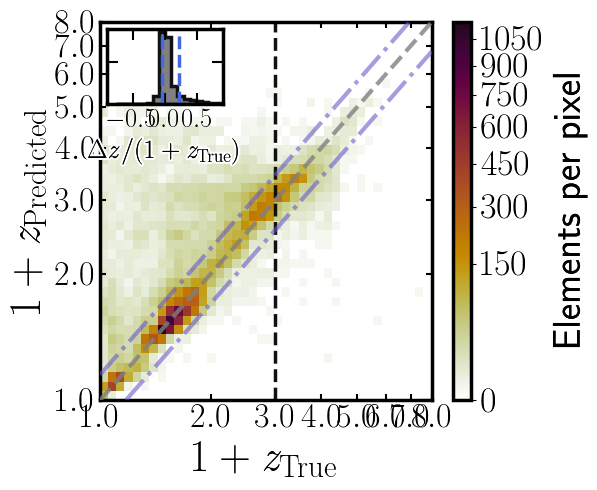

In [52]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
ax1 = gf.plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
ax1.axvline(x=(1 + gv.high_z_limit), ls='--', c='k', lw=2.5)
if use_second_z_model:
    ax1.set_ylabel('$1 + \mathit{z}_{\mathrm{Predicted}}^{\mathrm{combined\,models}}$', size=20)
plt.show()

Additional columns with radio AGN prediction as a whole.

In [53]:
full_catalog_df['pred_radio_AGN']     = np.array(full_catalog_df.loc[:, 'pred_star']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
full_catalog_df['pred_prob_rAGN']     = np.array(full_catalog_df.loc[:, 'pred_star_cal']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_radio_cal'] == 1)
full_catalog_df['Score_rAGN']         = full_catalog_df.loc[:, 'Score_no_star'] *\
                                        full_catalog_df.loc[:, 'Score_AGN'] *\
                                        full_catalog_df.loc[:, 'Score_radio']
full_catalog_df['Prob_rAGN']          = full_catalog_df.loc[:, 'Prob_no_star'] *\
                                        full_catalog_df.loc[:, 'Prob_AGN'] *\
                                        full_catalog_df.loc[:, 'Prob_radio']
rad_score_scaler                      = MinMaxScaler()
rad_score_scaler.fit(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_radio'] = rad_score_scaler.transform(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_rAGN']  = full_catalog_df.loc[:, 'Score_AGN'] * full_catalog_df.loc[:, 'scaled_score_radio']

In [54]:
unknown_cat_df['pred_radio_AGN']     = np.array(unknown_cat_df.loc[:, 'pred_star']  == 0) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_class'] == 1) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_radio'] == 1)
unknown_cat_df['pred_prob_rAGN']     = np.array(unknown_cat_df.loc[:, 'pred_star_cal']  == 0) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_class_cal'] == 1) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_radio_cal'] == 1)
unknown_cat_df['Score_rAGN']         = unknown_cat_df.loc[:, 'Score_no_star'] *\
                                       unknown_cat_df.loc[:, 'Score_AGN'] *\
                                       unknown_cat_df.loc[:, 'Score_radio']
unknown_cat_df['Prob_rAGN']          = unknown_cat_df.loc[:, 'Prob_no_star'] *\
                                       unknown_cat_df.loc[:, 'Prob_AGN'] *\
                                       unknown_cat_df.loc[:, 'Prob_radio']

unknown_cat_df['scaled_score_radio'] = rad_score_scaler.transform(unknown_cat_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
unknown_cat_df['scaled_score_rAGN']  = unknown_cat_df.loc[:, 'Score_AGN'] * unknown_cat_df.loc[:, 'scaled_score_radio']

In [55]:
if metrics_hiz_AGN:
    hiz_catalog_df['pred_radio_AGN']     = np.array(hiz_catalog_df.loc[:, 'pred_class'] == 1) &\
                                           np.array(hiz_catalog_df.loc[:, 'pred_radio'] == 1)
    hiz_catalog_df['pred_prob_rAGN']     = np.array(hiz_catalog_df.loc[:, 'pred_class_cal'] == 1) &\
                                           np.array(hiz_catalog_df.loc[:, 'pred_radio_cal'] == 1)
    hiz_catalog_df['Score_rAGN']         = hiz_catalog_df.loc[:, 'Score_AGN'] *\
                                           hiz_catalog_df.loc[:, 'Score_radio']
    hiz_catalog_df['Prob_rAGN']          = hiz_catalog_df.loc[:, 'Prob_AGN'] *\
                                           hiz_catalog_df.loc[:, 'Prob_radio']

In [56]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'pred_class_cal', 'LOFAR_detect', 'pred_radio', 'pred_radio_cal', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
initial_stats_preds = full_catalog_df.loc[:, displayed_cols].describe().transpose()
initial_stats_preds.loc[:, 'count'] = initial_stats_preds.loc[:, 'count'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(initial_stats_preds)

,count,mean,std,min,25%,50%,75%,max
class,23747,0.4257,0.4945,0.0000,0.0000,0.0000,1.0000,1.0000
pred_class,23747,0.4273,0.4947,0.0000,0.0000,0.0000,1.0000,1.0000
pred_class_cal,23747,0.4334,0.4956,0.0000,0.0000,0.0000,1.0000,1.0000
LOFAR_detect,23747,0.1545,0.3614,0.0000,0.0000,0.0000,0.0000,1.0000
pred_radio,23747,0.0000,0.0065,0.0000,0.0000,0.0000,0.0000,1.0000
pred_radio_cal,23747,0.5015,0.5000,0.0000,0.0000,1.0000,1.0000,1.0000
Z,23747,0.9510,0.7392,-0.0036,0.4785,0.6695,1.3795,6.5800
pred_Z,23747,1.1330,0.8051,0.0186,0.5151,0.7689,1.8091,4.5528


##### Obtain statistics for original redshift by class in known sources.

In [57]:
kno_summary_class                        = full_catalog_df.loc[:, 'Z'].groupby(full_catalog_df.loc[:, 'class']).describe()
kno_summary_radio_det                    = full_catalog_df.loc[:, 'Z'].groupby(full_catalog_df.loc[:, 'LOFAR_detect']).describe()
kno_summary_radio_AGN                    = full_catalog_df.loc[:, 'Z'].groupby(full_catalog_df.loc[:, 'radio_AGN']).describe()

kno_summary_ground_truth                 = pd.concat([kno_summary_class, kno_summary_radio_det, kno_summary_radio_AGN])
kno_summary_ground_truth['Class']        = ['Galaxy', 'AGN', 'No radio detected', 'Radio detected', 'No radio AGN', 'Radio AGN']

kno_summary_ground_truth                 = kno_summary_ground_truth.set_index('Class', drop=True)
kno_summary_ground_truth.loc[:, 'count'] = kno_summary_ground_truth.loc[:, 'count'].astype(int)

In [58]:
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(kno_summary_ground_truth)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Galaxy,13639,0.49599,0.24464,-0.00357,0.34895,0.52549,0.64006,2.10000
AGN,10108,1.56484,0.73956,0.00700,1.04200,1.54000,2.03000,6.58000
No radio detected,20079,0.97566,0.73536,-0.00357,0.49509,0.68666,1.42200,6.58000
Radio detected,3668,0.81570,0.74587,0.00000,0.26969,0.58294,1.14825,4.68000
No radio AGN,22083,0.92467,0.72405,-0.00357,0.47521,0.64985,1.30800,6.58000
Radio AGN,1664,1.29969,0.84327,0.00700,0.58850,1.25050,1.87650,4.68000


##### Include AGN detection criteria from literature

In [59]:
full_catalog_df = add_AGN_criteria(full_catalog_df)
unknown_cat_df  = add_AGN_criteria(unknown_cat_df)

Obtain intermediate metrics

In [60]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
if use_zeroth_model:
    filter_known_spec = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1) |\
                        (full_catalog_df.loc[:, 'class'] == 2)
elif not use_zeroth_model:
    filter_known_spec = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1)
total_size              = len(full_catalog_df)
filter_gal_t            = np.array(full_catalog_df.loc[:, 'class'] == 0)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
filter_str_t            = np.array(full_catalog_df.loc[:, 'class'] == 2)
filter_radio_t          = np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
num_str_t               = np.sum(filter_str_t)
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(filter_gal_t)
num_str_t               = np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_radio_t             = np.sum(filter_radio_t)
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [61]:
if use_zeroth_model:
    filter_non_str_p      = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_p      = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_p        = full_catalog_df.loc[:, 'pred_radio_AGN']
filt_hiz_rAGN_p           = filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_p              = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_non_str_p
filter_radio_p            = np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_p           = filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)
num_str_p                 = np.sum(full_catalog_df.loc[:, 'pred_star'] == 1)
num_AGN_p                 = np.sum(filter_AGN_p)
num_gal_p                 = np.sum(np.array(full_catalog_df.loc[:, 'pred_class'] == 0) & filter_non_str_p)
num_radio_p               = np.sum(filter_radio_p)
num_radio_AGN_p           = np.sum(filter_radio_AGN_p)
num_rAGN_MQC_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1))
num_new_rAGN_p            = np.sum(filter_radio_AGN_p) - np.sum(filter_radio_AGN_t)

Some metrics for predicted classes based on probabilities (not scores).

In [62]:
if use_zeroth_model:
    filter_non_str_prob_p = np.array(full_catalog_df.loc[:, 'pred_star_cal'] == 0)
elif not use_zeroth_model:
    filter_non_str_prob_p = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_prob_p   = full_catalog_df['pred_prob_rAGN']
filt_hiz_rAGN_prob_p      = filter_radio_AGN_prob_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_prob_p         = np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1) & filter_non_str_prob_p
filter_radio_prob_p       = np.array(full_catalog_df.loc[:, 'pred_radio_cal'] == 1)
filt_new_rAGN_prob_p      = filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)

num_AGN_prob_p            = np.sum(filter_AGN_prob_p)
num_gal_prob_p            = np.sum(np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 0) & filter_non_str_prob_p)
num_radio_prob_p          = np.sum(filter_radio_prob_p)
num_radio_AGN_prob_p      = np.sum(filter_radio_AGN_prob_p)
num_rAGN_MQC_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1))
num_new_rAGN_prob_p       = np.sum(filter_radio_AGN_prob_p) - np.sum(filter_radio_AGN_t)

In [63]:
if use_zeroth_model:
    filter_non_str_unk_p      = np.array(unknown_cat_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_unk_p      = np.ones_like(unknown_cat_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_unk_p        = unknown_cat_df['pred_radio_AGN']
filt_hiz_rAGN_unk_p           = filter_radio_AGN_unk_p * np.array(unknown_cat_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_unk_p              = np.array(unknown_cat_df.loc[:, 'pred_class'] == 1) & filter_non_str_unk_p
filter_radio_unk_p            = np.array(unknown_cat_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_unk_p           = filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'radio_AGN'] == 0)
num_str_unk_p                 = np.sum(unknown_cat_df.loc[:, 'pred_star'] == 1)
num_AGN_unk_p                 = np.sum(filter_AGN_unk_p)
num_gal_unk_p                 = np.sum(np.array(unknown_cat_df.loc[:, 'pred_class'] == 0) & filter_non_str_unk_p)
num_radio_unk_p               = np.sum(filter_radio_unk_p)
num_radio_AGN_unk_p           = np.sum(filter_radio_AGN_unk_p)
num_rAGN_MQC_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'class'] == 1))
num_rAGN_gal_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'class'] == 0))
num_rAGN_str_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'LOFAR_detect'] == 1))

In [64]:
if use_zeroth_model:
    filter_non_str_unk_prob_p = np.array(unknown_cat_df.loc[:, 'pred_star_cal'] == 0)
elif not use_zeroth_model:
    filter_non_str_unk_prob_p = np.ones_like(unknown_cat_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_unk_prob_p   = unknown_cat_df['pred_prob_rAGN']
filt_hiz_rAGN_unk_prob_p      = filter_radio_AGN_unk_prob_p * np.array(unknown_cat_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_unk_prob_p         = np.array(unknown_cat_df.loc[:, 'pred_class_cal'] == 1) & filter_non_str_unk_prob_p
filter_radio_unk_prob_p       = np.array(unknown_cat_df.loc[:, 'pred_radio_cal'] == 1)
filt_new_rAGN_unk_prob_p      = filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'radio_AGN'] == 0)

num_AGN_unk_prob_p            = np.sum(filter_AGN_unk_prob_p)
num_gal_unk_prob_p            = np.sum(np.array(unknown_cat_df.loc[:, 'pred_class_cal'] == 0) & filter_non_str_unk_prob_p)
num_radio_unk_prob_p          = np.sum(filter_radio_unk_prob_p)
num_radio_AGN_unk_prob_p      = np.sum(filter_radio_AGN_unk_prob_p)
num_rAGN_MQC_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'class'] == 1))
num_rAGN_gal_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'class'] == 0))
num_rAGN_str_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'LOFAR_detect'] == 1))
num_new_rAGN_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p) - np.sum(filter_radio_AGN_t)

Confusion matrix for Star/not-star classification on confirmed sources (AGN + Galaxies + Stars)

In [65]:
if use_zeroth_model:
    cm_str        = gf.conf_mat_func(full_catalog_df.loc[:, 'is_str'], full_catalog_df.loc[:, 'pred_star'])
    cm_str_random = gf.conf_mat_random(full_catalog_df.loc[:, 'is_str'])

Confusion matrix for AGN prediction on confirmed sources (AGN/galaxies). Including initial prediction of not being star.

In [66]:
tmp_filt_AGN = filter_non_str_p * filter_known_spec
cm_AGN = gf.conf_mat_func(full_catalog_df.loc[filter_non_str_p, 'class'], 
                          full_catalog_df.loc[filter_non_str_p, 'pred_class'])

cm_AGN_prob = gf.conf_mat_func(full_catalog_df.loc[filter_non_str_p, 'class'], 
                               full_catalog_df.loc[filter_non_str_p, 'pred_class_cal'])

cm_AGN_random = gf.conf_mat_random(full_catalog_df.loc[filter_non_str_p, 'class'])

Confusion matrices from literature AGN criteria.

In [67]:
tmp_filt_sp_nostr = filter_known_spec * filter_non_str_p
cm_AGN_S12 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'S12_AGN'])

cm_AGN_M12 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'])

cm_AGN_M16 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'])

cm_AGN_B18 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'])

cm_AGN_C22 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'C22_AGN'])

Confusion matrix for radio detection prediction on confirmed sources (AGN/galaxies/stars)

In [68]:
cm_radio = gf.conf_mat_func(full_catalog_df.loc[filter_AGN_p, 'LOFAR_detect'], 
                            full_catalog_df.loc[filter_AGN_p, 'pred_radio'])

cm_radio_prob = gf.conf_mat_func(full_catalog_df.loc[filter_AGN_prob_p, 'LOFAR_detect'], 
                                 full_catalog_df.loc[filter_AGN_prob_p, 'pred_radio_cal'])

cm_radio_random      = gf.conf_mat_random(full_catalog_df.loc[filter_AGN_p, 'LOFAR_detect'])

cm_radio_random_prob = gf.conf_mat_random(full_catalog_df.loc[filter_AGN_prob_p, 'LOFAR_detect'])

# CM for sources as in training stages (application of model to known AGN)
cm_radio_prob_indep = gf.conf_mat_func(full_catalog_df.loc[filter_AGN_t, 'LOFAR_detect'], 
                                       full_catalog_df.loc[filter_AGN_t, 'pred_radio_cal'])

cm_radio_random_indep = gf.conf_mat_random(full_catalog_df.loc[filter_AGN_t, 'LOFAR_detect'])

Confusion matrix for radio AGN prediction on confirmed sources (AGN/galaxies/stars)

In [69]:
cm_rAGN             = gf.conf_mat_func(full_catalog_df.loc[:, 'radio_AGN'], 
                                       full_catalog_df.loc[:,'pred_radio_AGN'])

cm_rAGN_prob        = gf.conf_mat_func(full_catalog_df.loc[:, 'radio_AGN'], 
                                       full_catalog_df.loc[:,'pred_prob_rAGN'])

cm_rAGN_random      = gf.conf_mat_random(full_catalog_df.loc[:, 'radio_AGN'])

Metrics from redshift predictions.

In [70]:
sigma_mad_field            = gf.sigma_mad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_nmad_field           = gf.sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_field              = gf.sigma_z(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_norm_field         = gf.sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
out_frac_field             = gf.outlier_frac(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])

sigma_mad_prob_field       = gf.sigma_mad(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_nmad_prob_field      = gf.sigma_nmad(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_z_prob_field         = gf.sigma_z(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_z_norm_prob_field    = gf.sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
out_frac_prob_field        = gf.outlier_frac(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])

sigma_mad_prob_field_indep    = gf.sigma_mad(full_catalog_df.loc[filter_radio_AGN_t, 'Z'],    full_catalog_df.loc[filter_radio_AGN_t, 'pred_Z'])
sigma_nmad_prob_field_indep   = gf.sigma_nmad(full_catalog_df.loc[filter_radio_AGN_t, 'Z'],   full_catalog_df.loc[filter_radio_AGN_t, 'pred_Z'])
sigma_z_prob_field_indep      = gf.sigma_z(full_catalog_df.loc[filter_radio_AGN_t, 'Z'],      full_catalog_df.loc[filter_radio_AGN_t, 'pred_Z'])
sigma_z_norm_prob_field_indep = gf.sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_t, 'Z'], full_catalog_df.loc[filter_radio_AGN_t, 'pred_Z'])
out_frac_prob_field_indep     = gf.outlier_frac(full_catalog_df.loc[filter_radio_AGN_t, 'Z'], full_catalog_df.loc[filter_radio_AGN_t, 'pred_Z'])

In [71]:
filt_high_z_rAGN_p         = filter_radio_AGN_p * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_field_hiz        = gf.sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_nmad_field_hiz       = gf.sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_field_hiz          = gf.sigma_z(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_norm_field_hiz     = gf.sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
out_frac_field_hiz         = gf.outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])

filt_high_z_rAGN_prob_p         = filter_radio_AGN_prob_p * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_prob_field_hiz        = gf.sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_nmad_prob_field_hiz       = gf.sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_z_prob_field_hiz          = gf.sigma_z(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_z_norm_prob_field_hiz     = gf.sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
out_frac_prob_field_hiz         = gf.outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])

Plot histograms for scores.

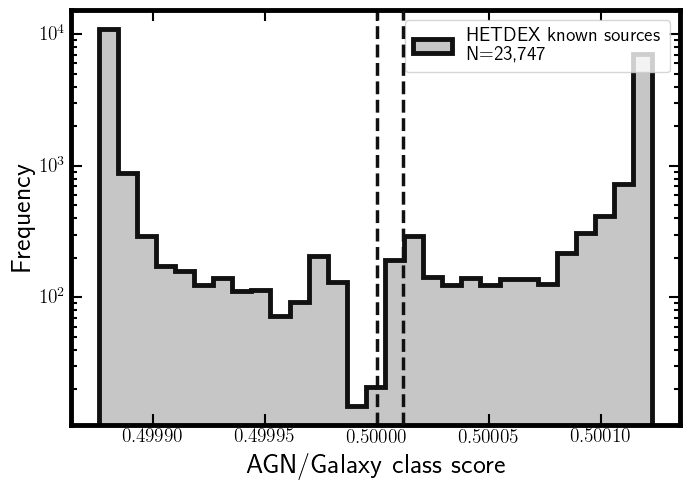

In [72]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5)
ax1.axvline(x=gv.AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_scores_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

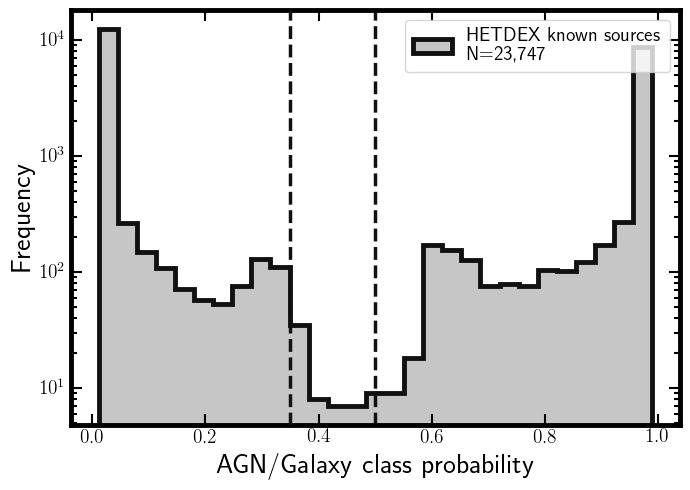

In [73]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5)
ax1.axvline(x=gv.cal_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_probs_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

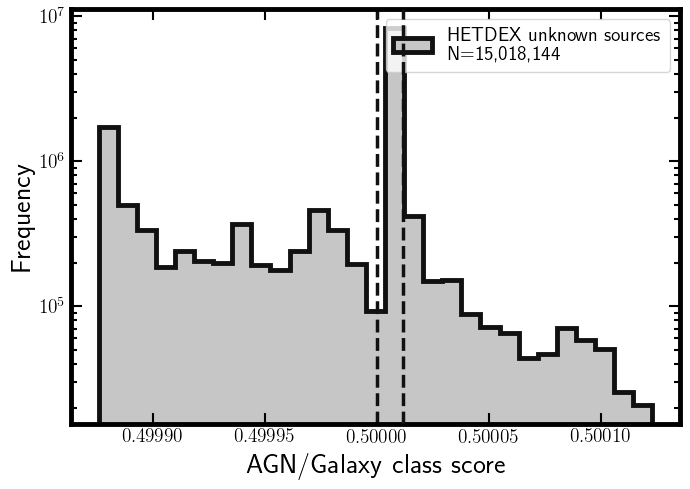

In [74]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'])
max_score  = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5)
ax1.axvline(x=gv.AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_scores_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

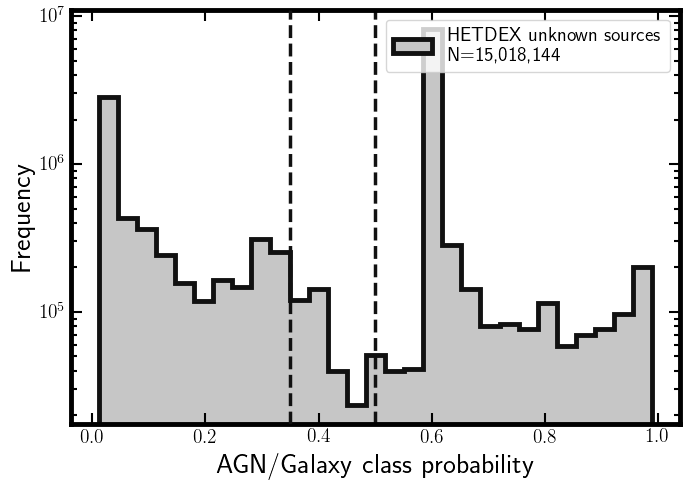

In [75]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'])
max_score  = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5)
ax1.axvline(x=gv.cal_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_probs_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

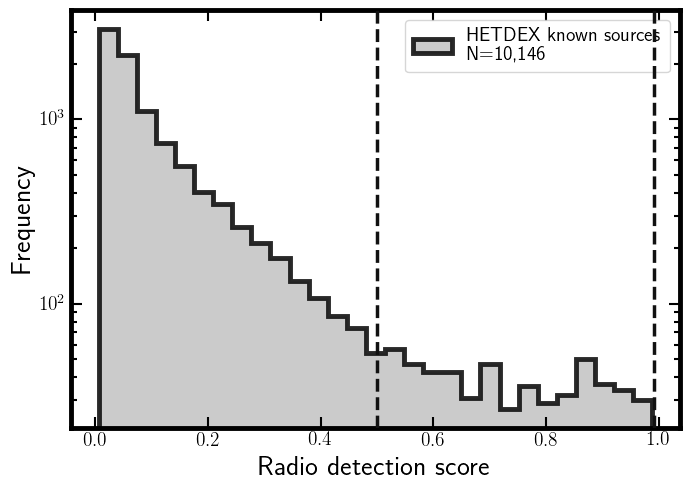

In [76]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_AGN_p, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[filter_AGN_p, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_p)

ax1.hist(full_catalog_df.loc[filter_AGN_p, 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
ax1.axvline(x=gv.radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_scores_pred_AGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

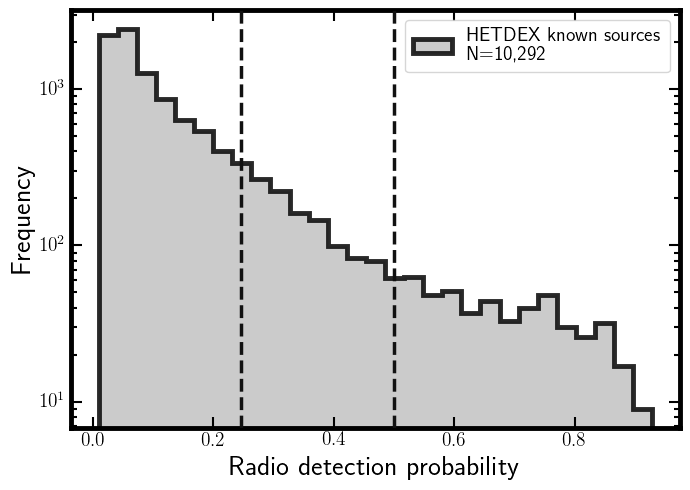

In [77]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_AGN_prob_p, 'Prob_radio'])
max_score       = np.nanmax(full_catalog_df.loc[filter_AGN_prob_p, 'Prob_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_prob_p)

ax1.hist(full_catalog_df.loc[filter_AGN_prob_p, 'Prob_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
ax1.axvline(x=gv.cal_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_prob_pred_AGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

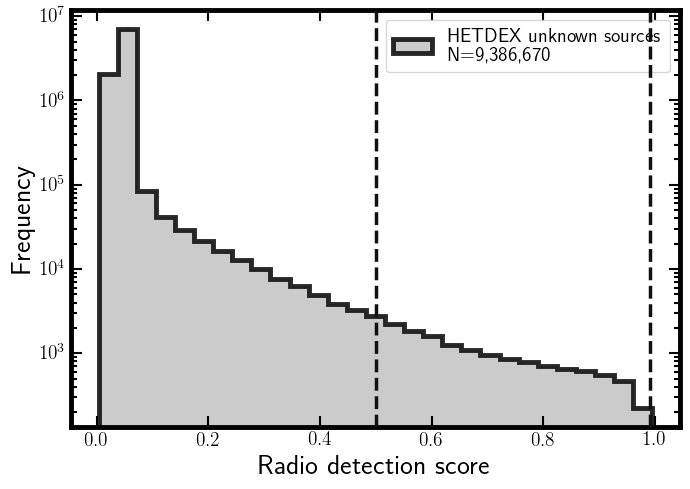

In [78]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
ax1.axvline(x=gv.radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_scores_pred_AGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

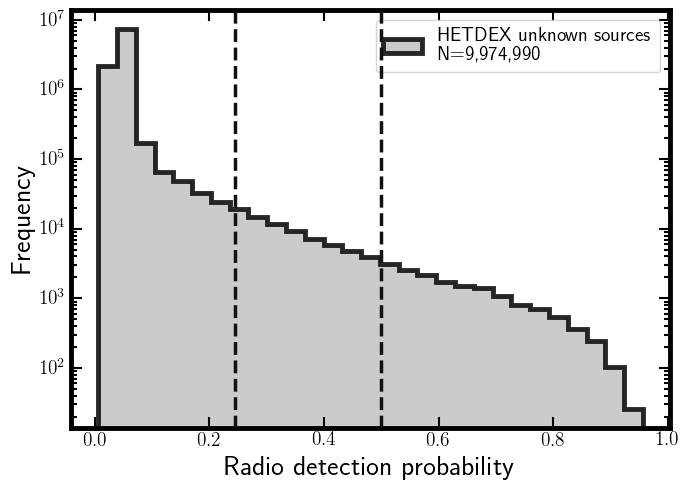

In [79]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_AGN_unk_prob_p, 'Prob_radio'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_AGN_unk_prob_p, 'Prob_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_unk_prob_p)

ax1.hist(unknown_cat_df.loc[filter_AGN_unk_prob_p, 'Prob_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
ax1.axvline(x=gv.cal_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_probs_pred_AGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

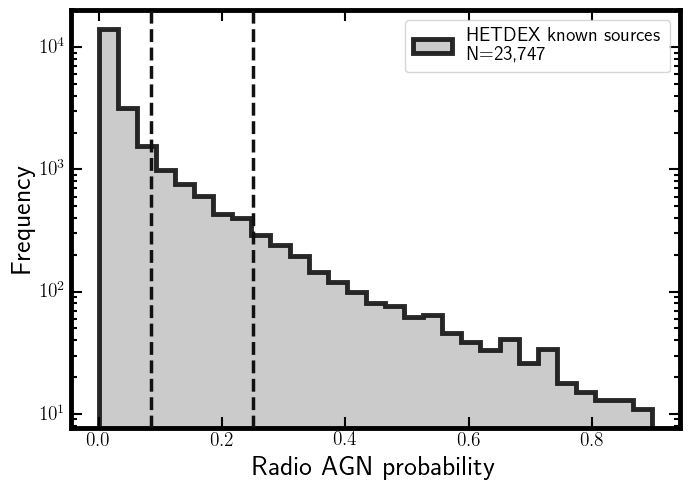

In [80]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'])
max_score       = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh * gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
ax1.axvline(x=gv.cal_AGN_thresh * gv.cal_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_rAGN_probs_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

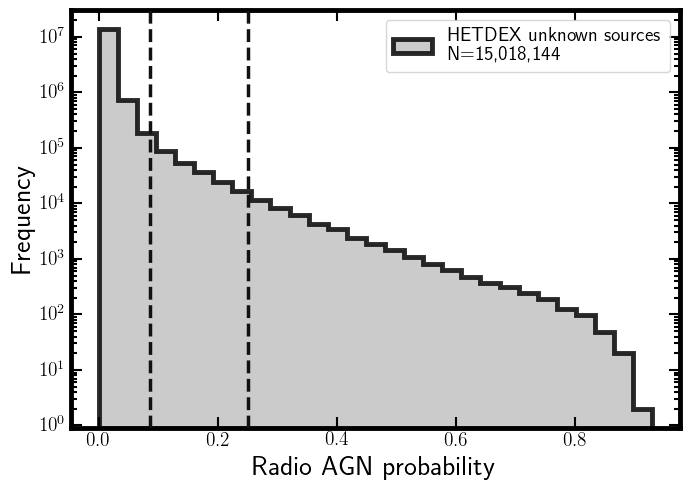

In [81]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_prob_p, 'Prob_rAGN'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_prob_p, 'Prob_rAGN'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_non_str_unk_prob_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_prob_p, 'Prob_rAGN'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh * gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
ax1.axvline(x=gv.cal_AGN_thresh * gv.cal_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_rAGN_probs_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

Plot histograms for predicted and original redshifts.

In [82]:
np.shape(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])

(0,)

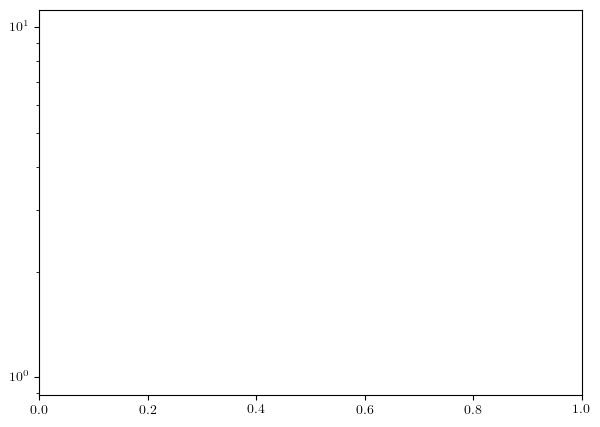

In [83]:
try:
    fig             = plt.figure(figsize=(7,5.0))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='log')
    
    min_score       = np.nanmin(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
    max_score       = np.nanmax(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
    score_bins      = np.linspace(min_score, max_score, 30)
    
    sample_size     = np.sum(filter_radio_AGN_p)
    
    ax1.hist(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'], bins=score_bins,\
             histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
             label=f'{used_area} known sources\nN={sample_size:,}')
    
    ax1.axvline(x=gv.high_z_limit, ls='--', c='k', lw=2.5, zorder=10)
        
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax1.set_xlabel('Predicted redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=14)
    plt.grid(False)
    #ax1.set_aspect('equal', 'box')
    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'hist_predicted_redshift_rAGN_known_{used_area}.pdf', bbox_inches='tight')
    plt.show()
except:
    pass

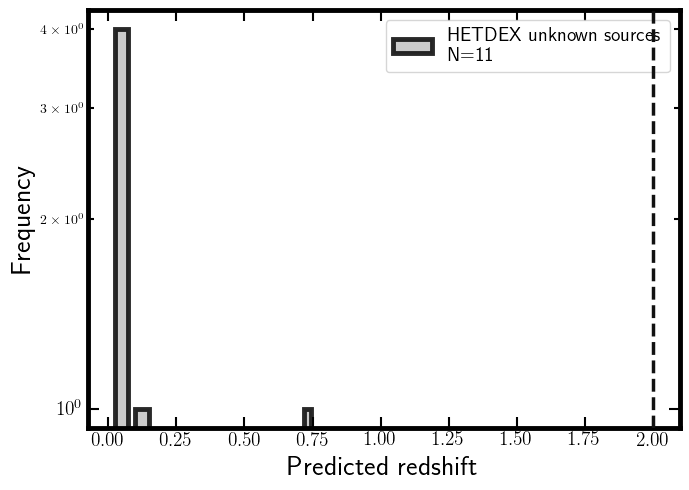

In [84]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_radio_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.high_z_limit, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_redshift_rAGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

In [85]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'LOFAR_detect', 'pred_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
print('Predictions for known sources:')
display(full_catalog_df.loc[filter_radio_AGN_p, displayed_cols].describe())
print('\nPredictions for unknown sources:')
display(unknown_cat_df.loc[filter_radio_AGN_unk_p, displayed_cols].describe())

Predictions for known sources:


,class,pred_class,LOFAR_detect,pred_radio,Z,pred_Z
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN



Predictions for unknown sources:


,class,pred_class,LOFAR_detect,pred_radio,Z,pred_Z
count,11.0,11.0,11.000000,11.0,1.0,11.000000
mean,0.5,1.0,0.272727,1.0,1.4,0.127755
std,0.0,0.0,0.467099,0.0,NaN,0.208000
min,0.5,1.0,0.000000,1.0,1.4,0.025000
25%,0.5,1.0,0.000000,1.0,1.4,0.034350
50%,0.5,1.0,0.000000,1.0,1.4,0.066800
75%,0.5,1.0,0.500000,1.0,1.4,0.096700
max,0.5,1.0,1.000000,1.0,1.4,0.743900


Add individual metrics for redshift

In [86]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [87]:
str_0_t     = f'Out of {total_size:,} initially known sources in {used_area},\n'
str_1_t     = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t     = f'{num_str_t:,} are listed as SDSS-DR16 stars and {num_AGN_t:,} are MQC AGN.\n'
str_3_t     = f'Also, {num_radio_AGN_t:,} AGN are detected in radio (i.e. Radio Galaxies).'

str_0_kno_p = f'Out of {len(full_catalog_df):,} initially known sources in {used_area},\n'
str_1_kno_p = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_kno_p = f'{num_str_p:,} are predicted as SDSS-DR16 stars and {num_AGN_p:,} are MQC AGN.\n'
str_3_kno_p = f'Also, {num_radio_AGN_p:,} AGN are predicted to bedetected in radio.'

str_0_unk_p = f'Out of {len(unknown_cat_df):,} initially unknown sources in {used_area},\n'
str_1_unk_p = f'{num_gal_unk_p:,} are predicted to be galaxies. On the other side,\n'
str_2_unk_p = f'{num_str_unk_p:,} are predicted as SDSS-DR16 stars and {num_AGN_unk_p:,} are MQC AGN.\n'
str_3_unk_p = f'Also, {num_radio_AGN_unk_p:,} AGN are predicted to be detected in radio.'

In [88]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)

print('-' * 60)
print(str_0_kno_p + str_1_kno_p + str_2_kno_p + str_3_kno_p)
print('-' * 60)

print('-' * 60)
print(str_0_unk_p + str_1_unk_p + str_2_unk_p + str_3_unk_p)
print('-' * 60)

------------------------------------------------------------
Out of 23,747 initially known sources in HETDEX,
13,639 are confirmed to be galaxies. On the other side,
0 are listed as SDSS-DR16 stars and 10,108 are MQC AGN.
Also, 1,664 AGN are detected in radio (i.e. Radio Galaxies).
------------------------------------------------------------
------------------------------------------------------------
Out of 23,747 initially known sources in HETDEX,
13,601 are predicted to be galaxies. On the other side,
0 are predicted as SDSS-DR16 stars and 10,146 are MQC AGN.
Also, 0 AGN are predicted to bedetected in radio.
------------------------------------------------------------
------------------------------------------------------------
Out of 15,018,144 initially unknown sources in HETDEX,
5,631,474 are predicted to be galaxies. On the other side,
0 are predicted as SDSS-DR16 stars and 9,386,670 are MQC AGN.
Also, 11 AGN are predicted to be detected in radio.
-------------------------------

In [89]:
show_columns = ['Name', 'RA_ICRS', 'DE_ICRS', 'TYPE', 'band_num', 'class', 'pred_class', 'Score_AGN',\
                'LOFAR_detect', 'pred_radio', 'scaled_score_radio', 'scaled_score_rAGN', 'Z', 'pred_Z']

# cols_4_table_pred_known   = ['RA_ICRS', 'DE_ICRS', 'band_num', 'class', 'Score_AGN', 'Prob_AGN', 'radio_detect',\
#                              'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'Z', 'pred_Z']
# cols_4_table_pred_unknown = ['RA_ICRS', 'DE_ICRS', 'band_num', 'Score_AGN', 'Prob_AGN', 'radio_detect',\
#                              'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'pred_Z']
cols_4_table_pred_known   = ['RA_ICRS', 'DE_ICRS', 'band_num', 'class', 'Score_AGN', 'Prob_AGN', 'LOFAR_detect',\
                             'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'Z', 'pred_Z']
cols_4_table_pred_unknown = ['RA_ICRS', 'DE_ICRS', 'band_num', 'Score_AGN', 'Prob_AGN', 'LOFAR_detect',\
                             'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'pred_Z']

In [90]:
cols_4_export_S82    = ['Total_flux_VLASS', 'Fint_VLAS82', 'Stotal_TGSS', 'FEP']
cols_4_export_HETDEX = ['Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS']
cols_4_export_COSMOS = ['Total_flux_VLASS', 'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3']

cols_4_exp_all       = {'S82': cols_4_export_S82, 'HETDEX': cols_4_export_HETDEX, 'COSMOS': cols_4_export_COSMOS}

cols_photo           = ['W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag',\
                        'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag']

cols_4_export        = show_columns + cols_4_exp_all[used_area] + cols_photo

In [91]:
filter_high_z   = full_catalog_df.loc[:, 'pred_Z']    >= gv.high_z_limit

Display properties of predicted Radio AGN in known sample.

In [92]:
disp_table_known = full_catalog_df.loc[filter_radio_AGN_prob_p, cols_4_table_pred_known].sort_values(by=['pred_Z'], ascending=False).head(5)
display(disp_table_known)

,RA_ICRS,DE_ICRS,band_num,class,Score_AGN,Prob_AGN,LOFAR_detect,Score_radio,Prob_radio,Score_rAGN,Prob_rAGN,Z,pred_Z
12308398,222.563293,49.665272,8,1.0,0.500061,0.906658,1,0.533024,0.477675,0.266544,0.433088,2.059,4.5143
10408176,188.163651,52.880898,9,1.0,0.500012,0.622448,0,0.811059,0.692809,0.405539,0.431238,4.340,4.0989
12612753,227.216370,51.941029,9,1.0,0.500055,0.887909,0,0.475636,0.435028,0.237844,0.386265,3.795,4.0606
5283988,210.532974,49.500351,9,1.0,0.500095,0.971223,0,0.250613,0.256745,0.125330,0.249356,3.800,3.9661
8721103,203.096924,50.575378,9,1.0,0.500093,0.969007,0,0.685156,0.590932,0.342641,0.572617,3.832,3.8436


LaTeX display of same table

In [93]:
display(disp_table_known.to_latex())

'\\begin{tabular}{lrrrrrrrrrrrrr}\n\\toprule\n{} &     RA\\_ICRS &    DE\\_ICRS &  band\\_num &  class &  Score\\_AGN &  Prob\\_AGN &  LOFAR\\_detect &  Score\\_radio &  Prob\\_radio &  Score\\_rAGN &  Prob\\_rAGN &      Z &  pred\\_Z \\\\\n\\midrule\n12308398 &  222.563293 &  49.665272 &         8 &    1.0 &   0.500061 &  0.906658 &             1 &     0.533024 &    0.477675 &    0.266544 &   0.433088 &  2.059 &  4.5143 \\\\\n10408176 &  188.163651 &  52.880898 &         9 &    1.0 &   0.500012 &  0.622448 &             0 &     0.811059 &    0.692809 &    0.405539 &   0.431238 &  4.340 &  4.0989 \\\\\n12612753 &  227.216370 &  51.941029 &         9 &    1.0 &   0.500055 &  0.887909 &             0 &     0.475636 &    0.435028 &    0.237844 &   0.386265 &  3.795 &  4.0606 \\\\\n5283988  &  210.532974 &  49.500351 &         9 &    1.0 &   0.500095 &  0.971223 &             0 &     0.250613 &    0.256745 &    0.125330 &   0.249356 &  3.800 &  3.9661 \\\\\n8721103  &  203.096924 &  50.575

Display properties predicted Radio AGN in unknown sample.

In [94]:
disp_table_unk = unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, cols_4_table_pred_unknown].sort_values(by=['pred_Z'], ascending=False).head(5)
display(disp_table_unk)

,RA_ICRS,DE_ICRS,band_num,Score_AGN,Prob_AGN,LOFAR_detect,Score_radio,Prob_radio,Score_rAGN,Prob_rAGN,pred_Z
3044266,178.612915,56.486168,6,0.500029,0.751100,0,0.466157,0.427926,0.233092,0.321415,4.6962
14184374,221.883484,56.382767,8,0.499999,0.504809,0,0.434600,0.404115,0.217300,0.204001,4.6830
170653,165.249878,46.125088,8,0.500033,0.779213,0,0.493832,0.448608,0.246932,0.349561,4.6683
6518790,180.627731,48.921600,7,0.500005,0.560952,0,0.796059,0.679788,0.398034,0.381329,4.6648
7638684,198.199402,45.742893,8,0.500004,0.548359,0,0.343504,0.333384,0.171753,0.182814,4.6647


LaTeX display of same table

In [95]:
display(disp_table_unk.to_latex())

'\\begin{tabular}{lrrrrrrrrrrr}\n\\toprule\n{} &     RA\\_ICRS &    DE\\_ICRS &  band\\_num &  Score\\_AGN &  Prob\\_AGN &  LOFAR\\_detect &  Score\\_radio &  Prob\\_radio &  Score\\_rAGN &  Prob\\_rAGN &  pred\\_Z \\\\\n\\midrule\n3044266  &  178.612915 &  56.486168 &         6 &   0.500029 &  0.751100 &             0 &     0.466157 &    0.427926 &    0.233092 &   0.321415 &  4.6962 \\\\\n14184374 &  221.883484 &  56.382767 &         8 &   0.499999 &  0.504809 &             0 &     0.434600 &    0.404115 &    0.217300 &   0.204001 &  4.6830 \\\\\n170653   &  165.249878 &  46.125088 &         8 &   0.500033 &  0.779213 &             0 &     0.493832 &    0.448608 &    0.246932 &   0.349561 &  4.6683 \\\\\n6518790  &  180.627731 &  48.921600 &         7 &   0.500005 &  0.560952 &             0 &     0.796059 &    0.679788 &    0.398034 &   0.381329 &  4.6648 \\\\\n7638684  &  198.199402 &  45.742893 &         8 &   0.500004 &  0.548359 &             0 &     0.343504 &    0.333384 &    0

Confusion matrix for AGN/galaxy prediction on all sources

In [96]:
MCC_AGN              = gf.MCC_from_CM(cm_AGN)
Fb_AGN               = gf.Fb_from_CM(cm_AGN)
Precision_AGN        = gf.Precision_from_CM(cm_AGN)
Recall_AGN           = gf.Recall_from_CM(cm_AGN)
ACC_AGN              = gf.ACC_from_CM(cm_AGN)

MCC_AGN_prob         = gf.MCC_from_CM(cm_AGN_prob)
ACC_AGN_prob         = gf.ACC_from_CM(cm_AGN_prob)
Fb_AGN_prob          = gf.Fb_from_CM(cm_AGN_prob)
Precision_AGN_prob   = gf.Precision_from_CM(cm_AGN_prob)
Recall_AGN_prob      = gf.Recall_from_CM(cm_AGN_prob)

MCC_AGN_random       = gf.MCC_from_CM(cm_AGN_random)
ACC_AGN_random       = gf.ACC_from_CM(cm_AGN_random)
Fb_AGN_random        = gf.Fb_from_CM(cm_AGN_random)
Precision_AGN_random = gf.Precision_from_CM(cm_AGN_random)
Recall_AGN_random    = gf.Recall_from_CM(cm_AGN_random)

Confusion matrix for radio detection prediction on all predicted AGN

In [97]:
MCC_radio                    = gf.MCC_from_CM(cm_radio)
ACC_radio                    = gf.ACC_from_CM(cm_radio)
Fb_radio                     = gf.Fb_from_CM(cm_radio)
Precision_radio              = gf.Precision_from_CM(cm_radio)
Recall_radio                 = gf.Recall_from_CM(cm_radio)

MCC_radio_prob               = gf.MCC_from_CM(cm_radio_prob)
ACC_radio_prob               = gf.ACC_from_CM(cm_radio_prob)
Fb_radio_prob                = gf.Fb_from_CM(cm_radio_prob)
Precision_radio_prob         = gf.Precision_from_CM(cm_radio_prob)
Recall_radio_prob            = gf.Recall_from_CM(cm_radio_prob)

MCC_radio_random             = gf.MCC_from_CM(cm_radio_random)
ACC_radio_random             = gf.ACC_from_CM(cm_radio_random)
Fb_radio_random              = gf.Fb_from_CM(cm_radio_random)
Precision_radio_random       = gf.Precision_from_CM(cm_radio_random)
Recall_radio_random          = gf.Recall_from_CM(cm_radio_random)

MCC_radio_random_prob        = gf.MCC_from_CM(cm_radio_random_prob)
ACC_radio_random_prob        = gf.ACC_from_CM(cm_radio_random_prob)
Fb_radio_random_prob         = gf.Fb_from_CM(cm_radio_random_prob)
Precision_radio_random_prob  = gf.Precision_from_CM(cm_radio_random_prob)
Recall_radio_random_prob     = gf.Recall_from_CM(cm_radio_random_prob)

MCC_radio_prob_indep         = gf.MCC_from_CM(cm_radio_prob_indep)
ACC_radio_prob_indep         = gf.ACC_from_CM(cm_radio_prob_indep)
Fb_radio_prob_indep          = gf.Fb_from_CM(cm_radio_prob_indep)
Precision_radio_prob_indep   = gf.Precision_from_CM(cm_radio_prob_indep)
Recall_radio_prob_indep      = gf.Recall_from_CM(cm_radio_prob_indep)

MCC_radio_random_indep       = gf.MCC_from_CM(cm_radio_random_indep)
ACC_radio_random_indep       = gf.ACC_from_CM(cm_radio_random_indep)
Fb_radio_random_indep        = gf.Fb_from_CM(cm_radio_random_indep)
Precision_radio_random_indep = gf.Precision_from_CM(cm_radio_random_indep)
Recall_radio_random_indep    = gf.Recall_from_CM(cm_radio_random_indep)

Confusion matrix for radio AGN detection prediction.

In [98]:
MCC_radio_AGN              = gf.MCC_from_CM(cm_rAGN)
ACC_radio_AGN              = gf.ACC_from_CM(cm_rAGN)
Fb_radio_AGN               = gf.Fb_from_CM(cm_rAGN)
Precision_radio_AGN        = gf.Precision_from_CM(cm_rAGN)
Recall_radio_AGN           = gf.Recall_from_CM(cm_rAGN)

MCC_radio_AGN_prob         = gf.MCC_from_CM(cm_rAGN_prob)
ACC_radio_AGN_prob         = gf.ACC_from_CM(cm_rAGN_prob)
Fb_radio_AGN_prob          = gf.Fb_from_CM(cm_rAGN_prob)
Precision_radio_AGN_prob   = gf.Precision_from_CM(cm_rAGN_prob)
Recall_radio_AGN_prob      = gf.Recall_from_CM(cm_rAGN_prob)

MCC_radio_AGN_random       = gf.MCC_from_CM(cm_rAGN_random)
ACC_radio_AGN_random       = gf.ACC_from_CM(cm_rAGN_random)
Fb_radio_AGN_random        = gf.Fb_from_CM(cm_rAGN_random)
Precision_radio_AGN_random = gf.Precision_from_CM(cm_rAGN_random)
Recall_radio_AGN_random    = gf.Recall_from_CM(cm_rAGN_random)

Join metrics for classification.

In [99]:
metrics_classif      = np.array([[np.sum(filter_known_spec), Fb_AGN,       MCC_AGN,       Precision_AGN,       Recall_AGN,       ACC_AGN],
                                 [np.sum(filter_AGN_p),      Fb_radio,     MCC_radio,     Precision_radio,     Recall_radio,     ACC_radio],
                                 [np.sum(filter_known_spec), Fb_radio_AGN, MCC_radio_AGN, Precision_radio_AGN, Recall_radio_AGN, ACC_radio_AGN]])
metrics_classif_df   = pd.DataFrame(data=metrics_classif, columns=['Sample', 'F-\u03B2', 'MCC', 'Precision', 'Recall', 'Accuracy'],
                                    index=['AGN/Galaxy', 'Radio pipeline', 'Radio AGN'])

metrics_classif_prob      = np.array([[np.sum(filter_known_spec), Fb_AGN_prob,         MCC_AGN_prob,         
                                       Precision_AGN_prob,         Recall_AGN_prob,         ACC_AGN_prob],
                                      [np.sum(filter_AGN_prob_p), Fb_radio_prob,       MCC_radio_prob,       
                                       Precision_radio_prob,       Recall_radio_prob,       ACC_radio_prob],
                                      [np.sum(filter_AGN_t),      Fb_radio_prob_indep, MCC_radio_prob_indep, 
                                       Precision_radio_prob_indep, Recall_radio_prob_indep, ACC_radio_prob_indep],
                                      [np.sum(filter_known_spec), Fb_radio_AGN_prob,   MCC_radio_AGN_prob,   
                                       Precision_radio_AGN_prob,   Recall_radio_AGN_prob,   ACC_radio_AGN_prob]])
metrics_classif_prob_df   = pd.DataFrame(data=metrics_classif_prob, 
                                         columns=['Sample', 'F-\u03B2', 'MCC', 'Precision', 'Recall', 'Accuracy'],
                                         index=['AGN/Galaxy', 'Radio pipeline', 'Radio indep', 'Radio AGN'])

metrics_classif_random    = np.array([[np.sum(filter_known_spec), Fb_AGN_random,         MCC_AGN_random,         
                                       Precision_AGN_random,         Recall_AGN_random,         ACC_AGN_random],
                                      [np.sum(filter_AGN_prob_p), Fb_radio_random,       MCC_radio_random,       
                                       Precision_radio_random,       Recall_radio_random,       ACC_radio_random],
                                      [np.sum(filter_AGN_t),      Fb_radio_random_indep, MCC_radio_random_indep, 
                                       Precision_radio_random_indep, Recall_radio_random_indep, ACC_radio_random_indep],
                                      [np.sum(filter_known_spec), Fb_radio_AGN_random,   MCC_radio_AGN_random,   
                                       Precision_radio_AGN_random,   Recall_radio_AGN_random,   ACC_radio_AGN_random]])

metrics_classif_random_df   = pd.DataFrame(data=metrics_classif_random, 
                                           columns=['Sample', 'F-\u03B2', 'MCC', 'Precision', 'Recall', 'Accuracy'], 
                                           index=['AGN/Galaxy', 'Radio pipeline', 'Radio indep', 'Radio AGN'])

Confusion matrices for AGN criteria from literature

In [100]:
MCC_AGN_S12          = gf.MCC_from_CM(cm_AGN_S12)
ACC_AGN_S12          = gf.ACC_from_CM(cm_AGN_S12)
Fb_AGN_S12           = gf.Fb_from_CM(cm_AGN_S12)
Precision_AGN_S12    = gf.Precision_from_CM(cm_AGN_S12)
Recall_AGN_S12       = gf.Recall_from_CM(cm_AGN_S12)

MCC_AGN_M12          = gf.MCC_from_CM(cm_AGN_M12)
ACC_AGN_M12          = gf.ACC_from_CM(cm_AGN_M12)
Fb_AGN_M12           = gf.Fb_from_CM(cm_AGN_M12)
Precision_AGN_M12    = gf.Precision_from_CM(cm_AGN_M12)
Recall_AGN_M12       = gf.Recall_from_CM(cm_AGN_M12)

MCC_AGN_M16          = gf.MCC_from_CM(cm_AGN_M16)
ACC_AGN_M16          = gf.ACC_from_CM(cm_AGN_M16)
Fb_AGN_M16           = gf.Fb_from_CM(cm_AGN_M16)
Precision_AGN_M16    = gf.Precision_from_CM(cm_AGN_M16)
Recall_AGN_M16       = gf.Recall_from_CM(cm_AGN_M16)

MCC_AGN_B18          = gf.MCC_from_CM(cm_AGN_B18)
ACC_AGN_B18          = gf.ACC_from_CM(cm_AGN_B18)
Fb_AGN_B18           = gf.Fb_from_CM(cm_AGN_B18)
Precision_AGN_B18    = gf.Precision_from_CM(cm_AGN_B18)
Recall_AGN_B18       = gf.Recall_from_CM(cm_AGN_B18)

MCC_AGN_C22          = gf.MCC_from_CM(cm_AGN_C22)
ACC_AGN_C22          = gf.ACC_from_CM(cm_AGN_C22)
Fb_AGN_C22           = gf.Fb_from_CM(cm_AGN_C22)
Precision_AGN_C22    = gf.Precision_from_CM(cm_AGN_C22)
Recall_AGN_C22       = gf.Recall_from_CM(cm_AGN_C22)

metrics_AGN_criteria    = np.array([[Fb_AGN_S12,        Fb_AGN_M12,        Fb_AGN_M16,        Fb_AGN_B18,        Fb_AGN_C22],\
                                    [MCC_AGN_S12,       MCC_AGN_M12,       MCC_AGN_M16,       MCC_AGN_B18,       MCC_AGN_C22],\
                                    [Precision_AGN_S12, Precision_AGN_M12, Precision_AGN_M16, Precision_AGN_B18, Precision_AGN_C22],\
                                    [Recall_AGN_S12,    Recall_AGN_M12,    Recall_AGN_M16,    Recall_AGN_B18,    Recall_AGN_C22],\
                                    [ACC_AGN_S12,       ACC_AGN_M12,       ACC_AGN_M16,       ACC_AGN_B18,       ACC_AGN_C22]]) 

metrics_AGN_criteria_df = pd.DataFrame(data=metrics_AGN_criteria.T, columns=['F-\u03B2', 'MCC', 'Precision', 'Recall', 'Accuracy'],\
                                       index=['S12', 'M12', 'M16', 'B18', 'C22'])

Join metrics for regression.

In [101]:
size_rAGN    = np.sum(filter_radio_AGN_p)
size_rAGN_hz = np.sum(filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit))
metrics_z    = np.array([[size_rAGN, sigma_mad_early, sigma_nmad_early, sigma_z_early, sigma_z_norm_early, out_frac_early],\
                         [size_rAGN, sigma_mad_field, sigma_nmad_field, sigma_z_field, sigma_z_norm_field, out_frac_field],\
                         [size_rAGN_hz, sigma_mad_early_hiz, sigma_nmad_early_hiz, sigma_z_early_hiz, sigma_z_norm_early_hiz, out_frac_early_hiz],\
                         [size_rAGN_hz, sigma_mad_field_hiz, sigma_nmad_field_hiz, sigma_z_field_hiz, sigma_z_norm_field_hiz, out_frac_field_hiz]])
metrics_z_df = pd.DataFrame(data=metrics_z,\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'],\
                            index=['First model only', 'Two models', 'First model high z', 'Second model high z'])

size_rAGN_prob    = np.sum(filter_radio_AGN_prob_p)
size_rAGN_prob_hz = np.sum(filter_radio_AGN_prob_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit))
metrics_z_prob    = np.array([[size_rAGN_prob, sigma_mad_prob_early, sigma_nmad_prob_early, sigma_z_prob_early,\
                               sigma_z_norm_prob_early, out_frac_prob_early],\
                         [size_rAGN_prob, sigma_mad_prob_field, sigma_nmad_prob_field, sigma_z_prob_field,\
                          sigma_z_norm_prob_field, out_frac_prob_field],\
                              [num_radio_AGN_t, sigma_mad_prob_field_indep, sigma_nmad_prob_field_indep, sigma_z_prob_field_indep,\
                          sigma_z_norm_prob_field_indep, out_frac_prob_field_indep],\
                         [size_rAGN_prob_hz, sigma_mad_prob_early_hiz, sigma_nmad_prob_early_hiz, sigma_z_prob_early_hiz,\
                          sigma_z_norm_prob_early_hiz, out_frac_prob_early_hiz],\
                         [size_rAGN_prob_hz, sigma_mad_prob_field_hiz, sigma_nmad_prob_field_hiz, sigma_z_prob_field_hiz,\
                          sigma_z_norm_prob_field_hiz, out_frac_prob_field_hiz]])
metrics_z_prob_df = pd.DataFrame(data=metrics_z_prob,\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'],\
                            index=['First model only', 'Two models', 'First model indep', 'First model high z', 'Second model high z'])

Print metrics

In [102]:
print('Metrics for classification steps along the pipeline using scores to obtain classes.')
metrics_classif_df.loc[:, 'Sample'] = metrics_classif_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_df.drop(columns=['Accuracy']))

Metrics for classification steps along the pipeline using scores to obtain classes.


,Sample,F-β,MCC,Precision,Recall
AGN/Galaxy,23747,0.9534,0.9184,0.9514,0.9550
Radio pipeline,10146,0.0000,NaN,NaN,0.0000
Radio AGN,23747,0.0000,NaN,NaN,0.0000


In [103]:
print('Metrics for classification steps along the pipeline using probabilities to obtain classes.')
metrics_classif_prob_df.loc[:, 'Sample'] = metrics_classif_prob_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_prob_df.drop(columns=['Accuracy']))

Metrics for classification steps along the pipeline using probabilities to obtain classes.


,Sample,F-β,MCC,Precision,Recall
AGN/Galaxy,23747,0.9542,0.9185,0.9449,0.9621
Radio pipeline,10292,0.4481,0.3380,0.4223,0.4718
Radio indep,10108,0.4648,0.3484,0.4332,0.4946
Radio AGN,23747,0.4017,0.3537,0.3870,0.4147


In [104]:
print('Metrics for classification steps along the pipeline using random guesses to obtain classes.')
metrics_classif_random_df.loc[:, 'Sample'] = metrics_classif_random_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_random_df.drop(columns=['Accuracy']))

Metrics for classification steps along the pipeline using random guesses to obtain classes.


,Sample,F-β,MCC,Precision,Recall
AGN/Galaxy,23747,0.4257,0.0000,0.4257,0.4257
Radio pipeline,10292,0.1527,0.0000,0.1527,0.1527
Radio indep,10108,0.1646,0.0000,0.1646,0.1646
Radio AGN,23747,0.0701,0.0000,0.0701,0.0701


In [105]:
print('Metrics for AGN detection criteria (from literature).')
print(f'Sample size, N = {np.sum(filter_known_spec):,}')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_AGN_criteria_df.drop(columns=['Accuracy']))

Metrics for AGN detection criteria (from literature).
Sample size, N = 23,747


,F-β,MCC,Precision,Recall
S12,0.8610,0.7878,0.9398,0.8051
M12,0.5180,0.4971,0.9887,0.3718
M16,0.6721,0.6130,0.9748,0.5348
B18,0.8214,0.7576,0.9754,0.7266
C22,0.9271,0.8764,0.9400,0.9167


In [106]:
print('Metrics for redshift predictions for sources predicted to be Radio AGN by scores')
metrics_z_df.loc[:, 'Sample'] = metrics_z_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_df)

Metrics for redshift predictions for sources predicted to be Radio AGN by scores


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
First model only,0,NaN,NaN,NaN,NaN,NaN
Two models,0,NaN,NaN,NaN,NaN,NaN
First model high z,0,NaN,NaN,NaN,NaN,NaN
Second model high z,0,NaN,NaN,NaN,NaN,NaN


In [107]:
print('Metrics for redshift predictions for sources predicted to be Radio AGN by probabilities')
metrics_z_prob_df.loc[:, 'Sample'] = metrics_z_prob_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_prob_df)

Metrics for redshift predictions for sources predicted to be Radio AGN by probabilities


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
First model only,1783,0.1424,0.0656,0.3731,0.2380,0.1699
Two models,1783,0.1424,0.0656,0.3731,0.2380,0.1699
First model indep,1664,0.1482,0.0664,0.3890,0.1820,0.1659
First model high z,366,0.2208,0.0643,0.5719,0.4022,0.1448
Second model high z,366,0.2208,0.0643,0.5719,0.4022,0.1448


## Plot predictions

### Classifications based on scores

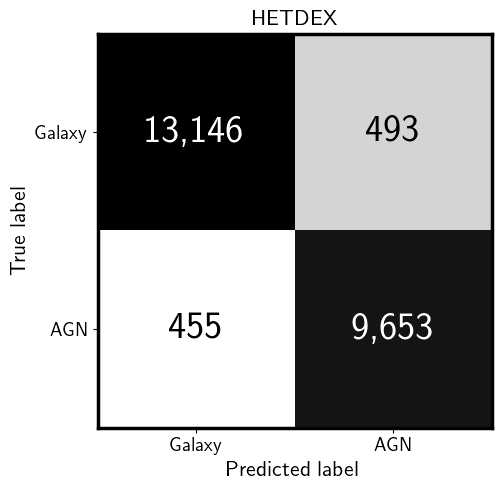

In [166]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_AGN, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[1].set_color('black')
ax1.texts[2].set_color('black')
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

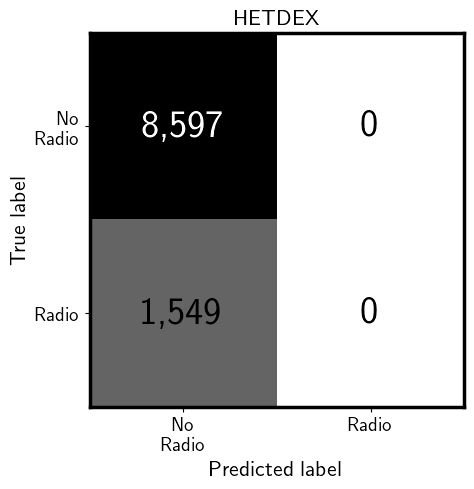

In [167]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_radio, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
ax1.texts[1].set_color('black')
ax1.texts[2].set_color('black')
ax1.texts[3].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_{used_area}.pdf', bbox_inches='tight')
plt.show()

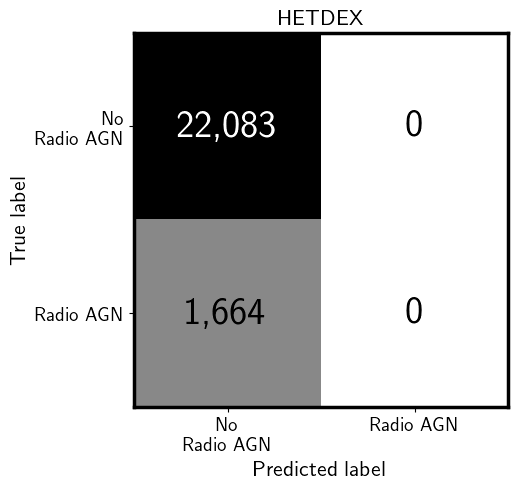

In [168]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_rAGN, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=False)
ax1.texts[1].set_color('black')
ax1.texts[2].set_color('black')
ax1.texts[3].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Classifications based on probabilities

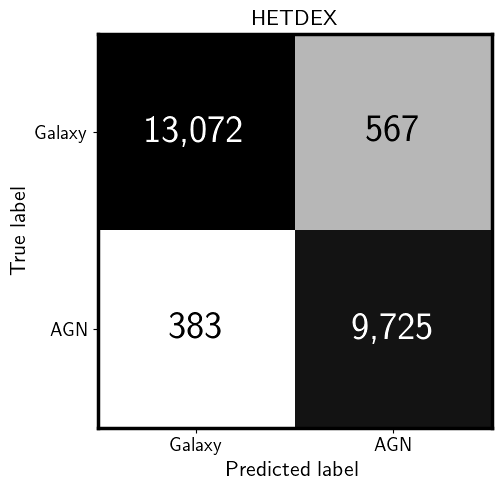

In [169]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_AGN_prob, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[1].set_color('black')
ax1.texts[2].set_color('black')
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_AGN_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

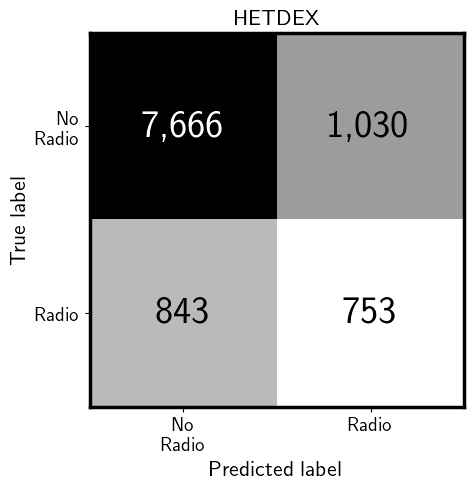

In [170]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_radio_prob, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
ax1.texts[1].set_color('black')
ax1.texts[2].set_color('black')
ax1.texts[3].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

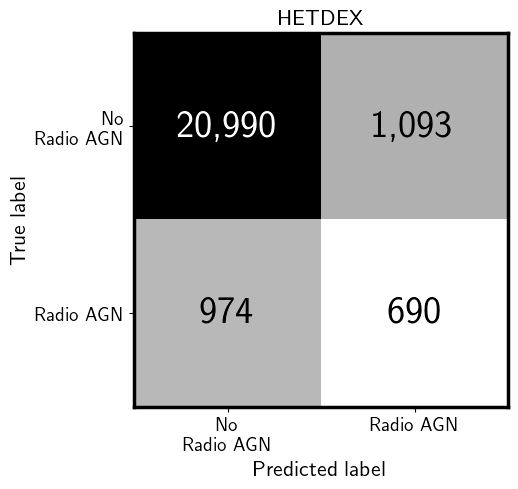

In [171]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_rAGN_prob, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=False)
ax1.texts[1].set_color('black')
ax1.texts[2].set_color('black')
ax1.texts[3].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_AGN_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Regression from sources by scores

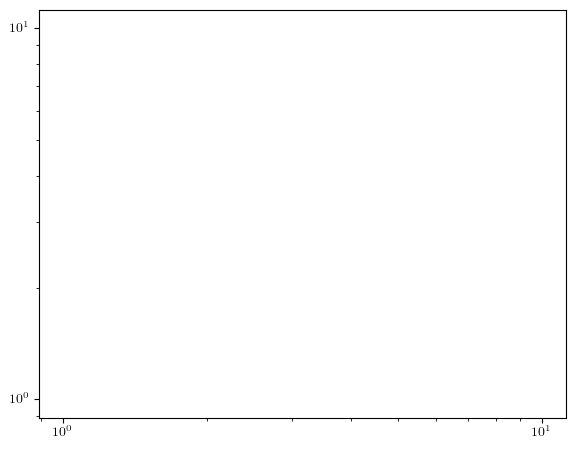

In [114]:
try:
    fig             = plt.figure(figsize=(6.8,5.3))
    ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
    _ = gf.plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'],\
                          ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
    
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'compare_redshift_{used_area}.pdf', bbox_inches='tight')
    plt.show()
except:
    pass

### Regression from sources by probabilities

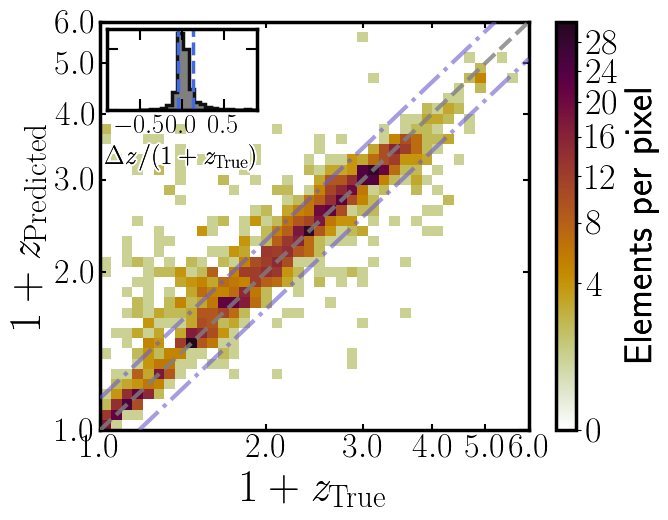

In [115]:
fig             = plt.figure(figsize=(6.8,5.3))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'compare_redshift_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Results from unknown sources

In [116]:
unk_summary_AGN_gal                   = unknown_cat_df.loc[:, 'Score_AGN'].groupby(unknown_cat_df.loc[:, 'pred_class']).describe()
unk_summary_AGN_gal_probs             = unknown_cat_df.loc[:, 'Prob_AGN'].groupby(unknown_cat_df.loc[:, 'pred_class_cal']).describe()
unk_summary_radio                     = unknown_cat_df.loc[filter_AGN_unk_p,
                                                         'Score_radio'].groupby(unknown_cat_df.loc[filter_AGN_unk_p,
                                                                                                   'pred_radio']).describe()
unk_summary_radio_probs               = unknown_cat_df.loc[filter_AGN_unk_prob_p,
                                                         'Prob_radio'].groupby(unknown_cat_df.loc[filter_AGN_unk_prob_p,
                                                                                                   'pred_radio_cal']).describe()
unk_summary_z                         = unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'].describe()
unk_summary_z_probs                   = unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'].describe()
unk_summary_AGN_radio                 = pd.concat([unk_summary_AGN_gal, unk_summary_AGN_gal_probs, unk_summary_radio, unk_summary_radio_probs])
unk_summary_AGN_radio['Prediction']   = ['Galaxy', 'AGN', 'Galaxy (prob)', 'AGN (prob)', 'No radio', 'Radio', 'No radio (prob)', 'Radio (prob)']
unk_summary_AGN_radio                 = unk_summary_AGN_radio.set_index('Prediction', drop=True)
unk_summary_AGN_radio.loc['Z']        = unk_summary_z
unk_summary_AGN_radio.loc['Z (prob)'] = unk_summary_z_probs

In [117]:
unk_summary_AGN_radio.loc[:, 'count'] = unk_summary_AGN_radio.loc[:, 'count'].astype(int)
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(unk_summary_AGN_radio)

,count,mean,std,min,25%,50%,75%,max
Prediction,,,,,,,,
Galaxy,5631474,0.49992,0.00004,0.49988,0.49988,0.49991,0.49996,0.50001
AGN,9386670,0.50002,0.00002,0.50001,0.50001,0.50001,0.50001,0.50012
Galaxy (prob),5043154,0.08801,0.10385,0.01135,0.01348,0.02734,0.12445,0.34856
AGN (prob),9974990,0.63125,0.08537,0.34939,0.61816,0.61816,0.61816,0.98931
No radio,9386659,0.04208,0.03760,0.00374,0.04065,0.04065,0.04065,0.99102
Radio,11,0.99284,0.00138,0.99128,0.99156,0.99321,0.99379,0.99541
No radio (prob),9887994,0.05022,0.01826,0.00568,0.05034,0.05180,0.05180,0.24490
Radio (prob),86996,0.39002,0.13588,0.24490,0.28604,0.34657,0.45436,0.95678
Z,11,0.12775,0.20800,0.02500,0.03435,0.06680,0.09670,0.74390


In [118]:
print(f"In the unknown sources, there are {np.sum(unknown_cat_df.loc[:, 'LOFAR_detect'] == 1):,} radio detected sources.")

In the unknown sources, there are 364,477 radio detected sources.


#### Same idea for known sample.

In [119]:
kno_summary_AGN_gal                   = full_catalog_df.loc[:, 'Score_AGN'].groupby(full_catalog_df.loc[:, 'pred_class']).describe()
kno_summary_AGN_gal_probs             = full_catalog_df.loc[:, 'Prob_AGN'].groupby(full_catalog_df.loc[:, 'pred_class_cal']).describe()
kno_summary_radio                     = full_catalog_df.loc[filter_AGN_p, 
                                                            'Score_radio'].groupby(full_catalog_df.loc[filter_AGN_p, 
                                                                                                       'pred_radio']).describe()
kno_summary_radio_probs               = full_catalog_df.loc[filter_AGN_prob_p,
                                                         'Prob_radio'].groupby(full_catalog_df.loc[filter_AGN_prob_p,
                                                                                                   'pred_radio_cal']).describe()
kno_summary_z                         = full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'].describe()
kno_summary_z_probs                   = full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'].describe()
kno_summary_AGN_radio                 = pd.concat([kno_summary_AGN_gal, kno_summary_AGN_gal_probs, kno_summary_radio, kno_summary_radio_probs])
# kno_summary_AGN_radio['Prediction']   = ['Galaxy', 'AGN', 'Galaxy (prob)', 'AGN (prob)', 'No radio', 'Radio', 'No radio (prob)', 'Radio (prob)']
kno_summary_AGN_radio['Prediction']   = ['Galaxy', 'AGN', 'Galaxy (prob)', 'AGN (prob)', 'No radio', 'No radio (prob)', 'Radio (prob)']
kno_summary_AGN_radio                 = kno_summary_AGN_radio.set_index('Prediction', drop=True)
kno_summary_AGN_radio.loc['Z']        = kno_summary_z
kno_summary_AGN_radio.loc['Z (prob)'] = kno_summary_z_probs

In [120]:
kno_summary_AGN_radio.loc[:, 'count'] = kno_summary_AGN_radio.loc[:, 'count'].astype(int)
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(kno_summary_AGN_radio)

,count,mean,std,min,25%,50%,75%,max
Prediction,,,,,,,,
Galaxy,13601,0.49989,0.00002,0.49988,0.49988,0.49988,0.49988,0.50001
AGN,10146,0.50011,0.00003,0.50001,0.50011,0.50012,0.50012,0.50012
Galaxy (prob),13455,0.02536,0.05024,0.01135,0.01176,0.01215,0.01378,0.34856
AGN (prob),10292,0.95314,0.09648,0.34939,0.98199,0.98792,0.98872,0.98939
No radio,10146,0.13962,0.17652,0.00621,0.03433,0.06819,0.16698,0.98854
No radio (prob),8509,0.08625,0.05781,0.00912,0.04009,0.06520,0.12024,0.24446
Radio (prob),1783,0.43184,0.17371,0.24499,0.29331,0.36591,0.53371,0.92928
Z,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Z (prob),1783,1.25077,0.77279,0.02230,0.64355,1.15660,1.84245,4.51430


In [121]:
print(f"In the known sources, there are {np.sum(full_catalog_df.loc[:, 'LOFAR_detect'] == 1):,} LOFAR radio detected sources.")

In the known sources, there are 3,668 LOFAR radio detected sources.


In [122]:
print(f"In the known sources, there are {np.sum((full_catalog_df.loc[:, 'LOFAR_detect'] == 1) & (full_catalog_df.loc[:, 'class'] == 1)):,} LOFAR radio detected AGN.")

In the known sources, there are 1,664 LOFAR radio detected AGN.


#### Some properties from predicted Radio AGN

In [123]:
n_pred_rAGN_AGN_sco      = len(full_catalog_df.loc[filter_radio_AGN_p * filter_AGN_t])
n_pred_rAGN_gal_sco      = len(full_catalog_df.loc[filter_radio_AGN_p * filter_gal_t])
n_pred_rAGN_radio_sco    = len(full_catalog_df.loc[filter_radio_AGN_p * filter_radio_t])
n_pred_rAGN_nonradio_sco = len(full_catalog_df.loc[filter_radio_AGN_p * ~filter_radio_t])

In [124]:
str_rAGN_stats_class_sco = f'From {num_radio_AGN_p:,} sources predicted as rAGN,' +\
                           f' {n_pred_rAGN_gal_sco:,} are galaxies and {n_pred_rAGN_AGN_sco:,} are AGN.'
str_rAGN_stats_radio_sco = f'From {num_radio_AGN_p:,} sources predicted as rAGN, {n_pred_rAGN_radio_sco:,}' +\
                           f' are radio detected and {n_pred_rAGN_nonradio_sco:,} are not.'

In [125]:
print('-' * 80)
print('Statistics from sources predicted to be Radio AGN')
print(f'with scores in the known sources of {used_area}-{HETDEX_subset}')
print()
print(str_rAGN_stats_class_sco)
print(str_rAGN_stats_radio_sco)
print('-' * 80)

--------------------------------------------------------------------------------
Statistics from sources predicted to be Radio AGN
with scores in the known sources of HETDEX-Validation

From 0 sources predicted as rAGN, 0 are galaxies and 0 are AGN.
From 0 sources predicted as rAGN, 0 are radio detected and 0 are not.
--------------------------------------------------------------------------------


In [126]:
n_pred_rAGN_AGN_pro      = len(full_catalog_df.loc[filter_radio_AGN_prob_p * filter_AGN_t])
n_pred_rAGN_gal_pro      = len(full_catalog_df.loc[filter_radio_AGN_prob_p * filter_gal_t])
n_pred_rAGN_radio_pro    = len(full_catalog_df.loc[filter_radio_AGN_prob_p * filter_radio_t])
n_pred_rAGN_nonradio_pro = len(full_catalog_df.loc[filter_radio_AGN_prob_p * ~filter_radio_t])

In [127]:
str_rAGN_stats_class_pro = f'From {num_radio_AGN_prob_p:,} sources predicted as rAGN,' +\
                           f' {n_pred_rAGN_gal_pro:,} are galaxies and {n_pred_rAGN_AGN_pro:,} are AGN.'
str_rAGN_stats_radio_pro = f'From {num_radio_AGN_prob_p:,} sources predicted as rAGN, {n_pred_rAGN_radio_pro:,}' +\
                           f' are radio detected and {n_pred_rAGN_nonradio_pro:,} are not.'

In [128]:
print('-' * 80)
print('Statistics from sources predicted to be Radio AGN')
print(f'with probabilities in the known sources of {used_area}-{HETDEX_subset}')
print()
print(str_rAGN_stats_class_pro)
print(str_rAGN_stats_radio_pro)
print('-' * 80)

--------------------------------------------------------------------------------
Statistics from sources predicted to be Radio AGN
with probabilities in the known sources of HETDEX-Validation

From 1,783 sources predicted as rAGN, 118 are galaxies and 1,665 are AGN.
From 1,783 sources predicted as rAGN, 753 are radio detected and 1,030 are not.
--------------------------------------------------------------------------------


#### Histograms for predicted sources in unknown sources.

Predictions from scores.

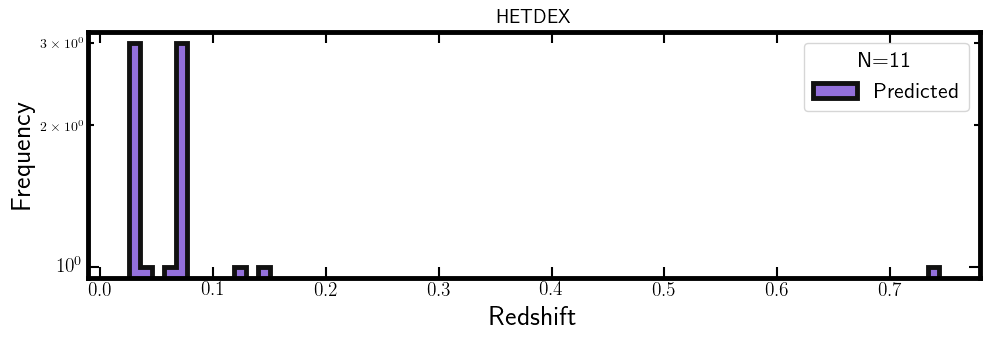

In [129]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
max_for_range = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
bins_z        = np.linspace(min_for_range, max_for_range, 70)

_, bins, _ = ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f'Predicted')

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16, title=f'N={np.sum(filter_radio_AGN_unk_p):,}', title_fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_z_{used_area}_unknown.pdf')
plt.show()

Predictions from probabilities.

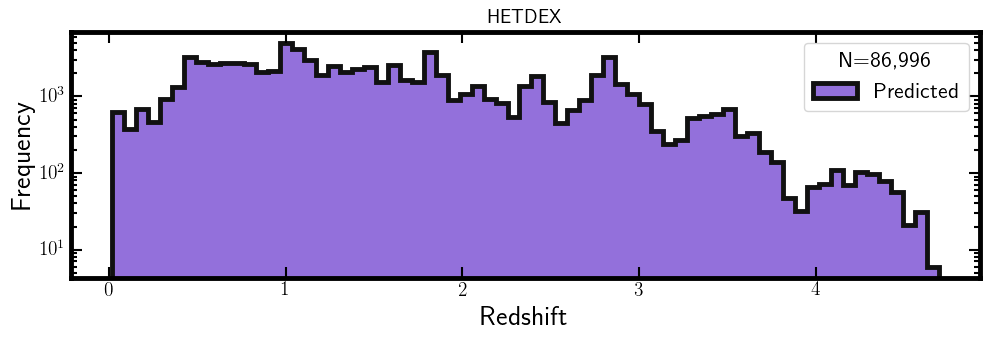

In [130]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'])
max_for_range = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'])
bins_z        = np.linspace(min_for_range, max_for_range, 70)

_, bins, _ = ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f'Predicted')

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16, title=f'N={np.sum(filter_radio_AGN_unk_prob_p):,}', title_fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_z_prob_{used_area}_unknown.pdf')
plt.show()

#### Histograms for predicted sources in known sources.

Predictions from scores.

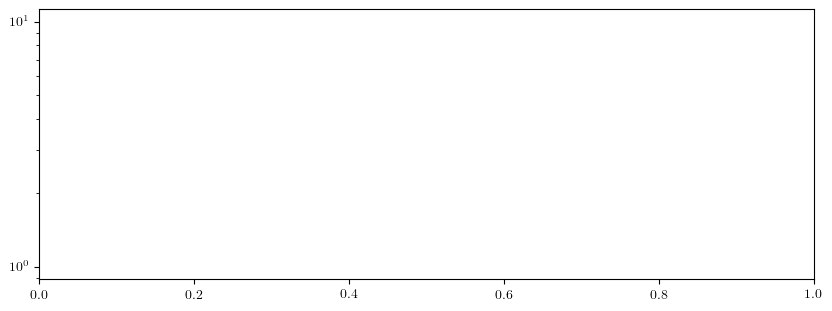

In [131]:
try:
    fig             = plt.figure(figsize=(10,3.5))
    ax1             = fig.add_subplot(111, xscale='linear', yscale='log')
    
    min_for_range = np.nanmin(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
    max_for_range = np.nanmax(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
    bins_z        = np.linspace(min_for_range, max_for_range, 70)
    
    _, bins, _ = ax1.hist(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                          ec='k', fc='mediumpurple', lw=3.5,\
                          label=f'Predicted')
    
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    # ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
    ax1.set_xlabel('Redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    # ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=16, title=f'N={np.sum(filter_radio_AGN_p):,}', title_fontsize=16)
    # ax1.invert_xaxis()
    # ax1.set_xlim(left=-4, right=6)
    #ax1.set_aspect('equal', 'box')
    ax1.set_title(used_area, fontsize=14)
    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'hist_predicted_z_{used_area}_known.pdf')
    plt.show()
except:
    pass

Predictions from probabilities.

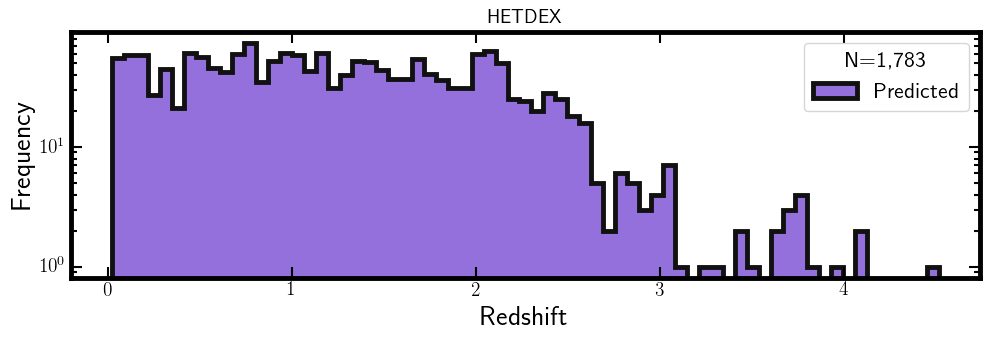

In [132]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin(full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
max_for_range = np.nanmax(full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
bins_z        = np.linspace(min_for_range, max_for_range, 70)

_, bins, _ = ax1.hist(full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f'Predicted')

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16, title=f'N={np.sum(filter_radio_AGN_prob_p):,}', title_fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_z_prob_{used_area}_known.pdf')
plt.show()

In [133]:
np.array(full_catalog_df.columns)

array(['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'Z', 'band_num',
       'LOFAR_detect', 'Sint_LOFAR', 'Sint_LOFAR_AB', 'Speak_LOFAR',
       'rms_LOFAR', 'Sint_LOFAR_non_imp', 'Sint_LOFAR_AB_non_imp',
       'Speak_LOFAR_non_imp', 'is_str', 'W1mproPM', 'W2mproPM', 'gmag',
       'rmag', 'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag',
       'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1',
       'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K',
       'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K',
       'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1',
       'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2',
       'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4',
       'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3',
       'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4',
       'class', 'radio_AGN', 'pred_star', 'Score_no_star', 'Prob_no_star',
   

In [134]:
used_z_rAGN = 'pred_Z'

In [135]:
lums_dist_rAGN = cosmo.luminosity_distance(full_catalog_df.loc[:, used_z_rAGN].values).to(u.m)
full_catalog_df.loc[:, 'lum_dist'] = lums_dist_rAGN.value

In [136]:
lums_rAGN = radio_lum(full_catalog_df.loc[:, int_flux_col].values * u.mJy, 
                      full_catalog_df.loc[:, used_z_rAGN].values, radio_alpha)
full_catalog_df.loc[:, 'lum_base'] = lums_rAGN.value

In [137]:
lums_rAGN_14_GHz = lums_rAGN * ((1.4 * u.GHz) / radio_freq.to(u.GHz))**radio_alpha
full_catalog_df.loc[:, 'lum_14_GHz']     = lums_rAGN_14_GHz.value
full_catalog_df.loc[:, 'log_lum_14_GHz'] = np.log10(lums_rAGN_14_GHz.value)

In [138]:
nstep = 4
seq_cont   = np.logspace(-1.5, 0.0, nstep)
seq_cont   = np.insert(seq_cont, 0, 0.0)
seq_fill   = np.logspace(-1.5, 0.0, nstep+2)
seq_fill   = np.insert(seq_fill, 0, 0.0)

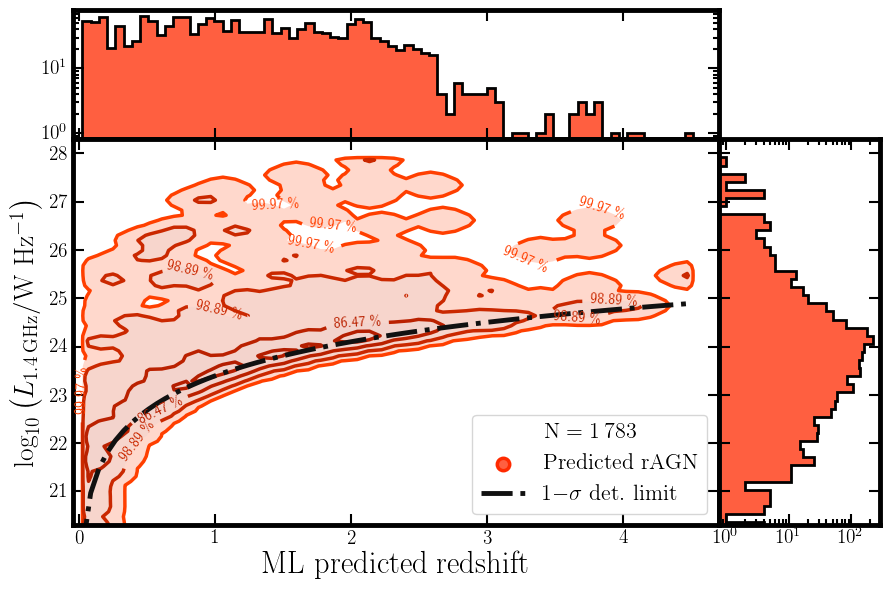

In [139]:
sigma_limit_flx = 1

fig    = plt.figure(figsize=(9, 6))
grid   = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[4, 1],
                          height_ratios=[1, 3], hspace=0.0, wspace=0.0)
axs    = {}
axs[0] = fig.add_subplot(grid[0, 0], yscale='log')
axs[1] = fig.add_subplot(grid[1, 0], yscale='linear', sharex=axs[0])
axs[2] = fig.add_subplot(grid[1, 1], xscale='log', yscale='linear', sharey=axs[1])

min_z = np.nanmin(full_catalog_df.loc[filter_radio_AGN_prob_p, used_z_rAGN].values)
max_z = np.nanmax(full_catalog_df.loc[filter_radio_AGN_prob_p, used_z_rAGN].values)

min_lum  = np.nanmin(lums_rAGN_14_GHz.value)
max_lum  = np.nanmax(lums_rAGN_14_GHz.value)

n_bins   = [50, 75]

bins_z   = np.linspace(min_z, max_z, n_bins[1])
# bins_lum = np.logspace(np.log10(min_lum), np.log10(max_lum), n_bins[0])
bins_lum = np.linspace(np.log10(min_lum), np.log10(max_lum), n_bins[0])

sigmas_perc     = [0.39346934, 0.86466472, 0.988891, 0.99966454]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc_inv = [1. - sigma for sigma in sigmas_perc][::-1]  # 1, 2, 3, 4 sigma

H_rAGN, xedges_rAGN, yedges_rAGN = np.histogram2d(full_catalog_df.loc[filter_radio_AGN_prob_p, used_z_rAGN], 
                                   full_catalog_df.loc[filter_radio_AGN_prob_p, 'log_lum_14_GHz'], bins=n_bins)

H_rAGN_smooth = clean_and_smooth_matrix(H_rAGN, sigma=1.5)

Z_rAGN = (H_rAGN_smooth.T - H_rAGN_smooth.T.min())/(H_rAGN_smooth.T.max() - H_rAGN_smooth.T.min())

# fix probable lines not closing
# Z_rAGN = make_borders_zero(Z_rAGN)
Z_rAGN, x_centers_rAGN, y_centers_rAGN = pad_matrix_zeros(Z_rAGN, xedges_rAGN, yedges_rAGN)

CS_rAGN_f = axs[1].contourf(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rAGN(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rAGN = axs[1].contour(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rAGN(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(2):  # times to run nex command, more labels
    ax1.clabel(CS_rAGN, CS_rAGN.levels, inline=True, fmt=fmt, fontsize=10)

axs[1].scatter([-1], [10], marker='o', edgecolor=colour_rAGN, color=colour_rAGN_shade, s=80, label='$\mathrm{Predicted ~ rAGN}$', linewidths=2.5)


axs[1].plot(bins_z, np.log10((radio_lum(sigma_limit_flx * limit_flux_survey_b * u.Jy, bins_z, radio_alpha) * ((1.4 * u.GHz) / (944 * u.MHz).to(u.GHz))**radio_alpha).value), 
            ls='-.', marker=None, color='k', label=rf'${sigma_limit_flx} {{-}} \sigma ~ \mathrm{{det. ~ limit}}$', lw=3.5)

axs[0].hist(full_catalog_df.loc[filter_radio_AGN_prob_p, used_z_rAGN], bins=bins_z, 
            histtype='stepfilled', fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)

axs[2].hist(np.log10(lums_rAGN_14_GHz.value)[filter_radio_AGN_prob_p], bins=bins_lum, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)

axs[1].legend(loc='lower right', fontsize=16, title=rf'$\mathrm{{N}} = {np.sum(filter_radio_AGN_prob_p):,}$'.replace(',', '$\,$'), title_fontsize=16)
axs[1].set_xlabel(r'$\mathrm{ML ~ predicted ~ redshift}$', fontsize=22)
axs[1].set_ylabel(r'$\log_{10}\left( L_{1.4\,\mathrm{GHz}} / \mathrm{W ~ Hz^{-1}} \right)$', fontsize=20)
for ax_count in [0, 1, 2]:
    axs[ax_count].tick_params(which='both', top=True, right=True, direction='in')
    axs[ax_count].tick_params(axis='both', which='major', labelsize=14)
    axs[ax_count].tick_params(which='major', length=8, width=1.5)
    axs[ax_count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
plt.setp(axs[2].get_yticklabels(), visible=False)
axs[1].set_ylim(bottom=20.3, top=28.3)
axs[1].set_xlim(left=-0.05, right=4.7)
plt.tight_layout()
plt.show()

### Assess probabilities and compare with scores

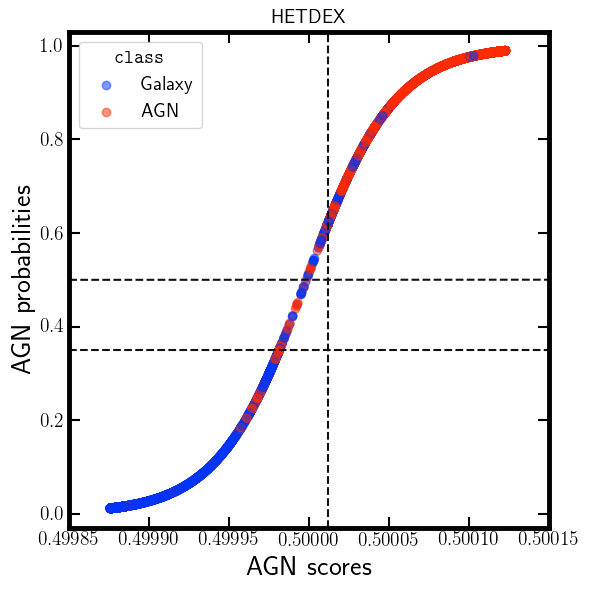

In [140]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

ax1.scatter(full_catalog_df.loc[:, 'Score_AGN'], full_catalog_df.loc[:, 'Prob_AGN'], marker='o',\
            alpha=0.5, c=full_catalog_df.loc[:, 'class'],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'class']))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=gv.cal_AGN_thresh, color='k', ls='dashed')
ax1.axvline(x=gv.AGN_thresh, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Galaxy',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'class'])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='AGN',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'class'])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores', size=20)
ax1.set_ylabel('AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{class}$', title_fontsize=14)
# ax1.set_xlim(left=-0.03, right=1.03)
# ax1.set_xlim(left=0.38, right=0.61)
ax1.set_xlim(left=0.49985, right=0.50015)
ax1.set_ylim(bottom=-0.03, top=1.03)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

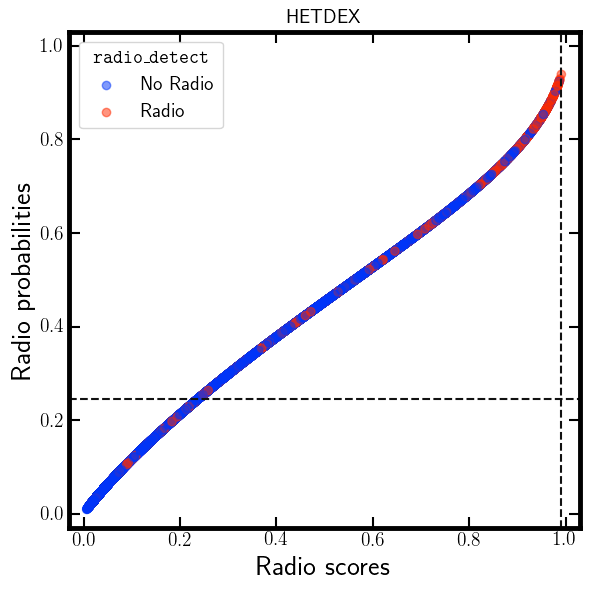

In [141]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

ax1.scatter(full_catalog_df.loc[:, 'Score_radio'], full_catalog_df.loc[:, 'Prob_radio'], marker='o',\
            alpha=0.5, c=full_catalog_df.loc[:, 'LOFAR_detect'],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'LOFAR_detect']))))
# ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=gv.cal_radio_thresh, color='k', ls='dashed')
ax1.axvline(x=gv.radio_thresh, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='No Radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'LOFAR_detect'])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'LOFAR_detect'])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio scores', size=20)
ax1.set_ylabel('Radio probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_detect}$', title_fontsize=14)
# ax1.set_xlim(left=full_catalog_df.loc[:, 'Score_radio'].min() * 0.99999, right=full_catalog_df.loc[:, 'Score_radio'].max() * 1.00001)
ax1.set_xlim(left=-0.03, right=1.03)
ax1.set_ylim(bottom=-0.03, top=1.03)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

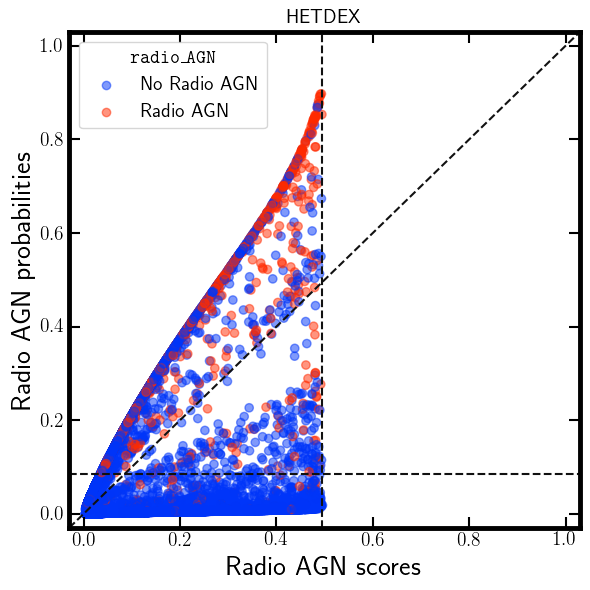

In [142]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

ax1.scatter(full_catalog_df.loc[:, 'Score_rAGN'], full_catalog_df.loc[:, 'Prob_rAGN'], marker='o',\
            alpha=0.5, c=full_catalog_df.loc[:, 'radio_AGN'],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'radio_AGN']))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=(gv.cal_AGN_thresh * gv.cal_radio_thresh), color='k', ls='dashed')
ax1.axvline(x=(gv.AGN_thresh * gv.radio_thresh), color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='No Radio AGN',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'radio_AGN'])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Radio AGN',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'radio_AGN'])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN scores', size=20)
ax1.set_ylabel('Radio AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_AGN}$', title_fontsize=14)
ax1.set_xlim(left=-0.03, right=1.03)
ax1.set_ylim(bottom=-0.03, top=1.03)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

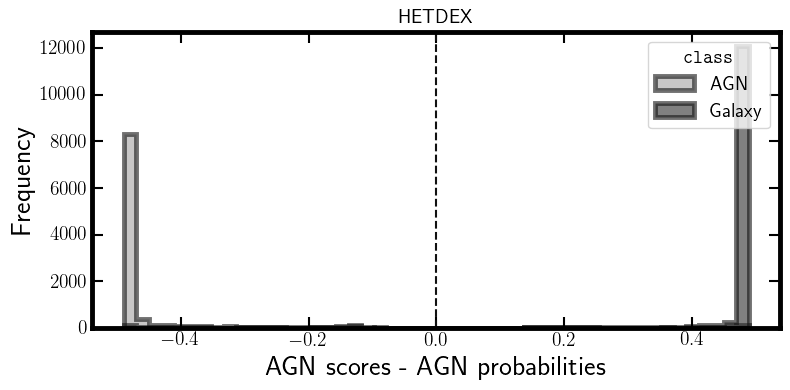

In [143]:
fig             = plt.figure(figsize=(8,4))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

filt_tmp_AGN    = np.array(full_catalog_df.loc[:, 'class'] == 1)

plt.hist((full_catalog_df.loc[filt_tmp_AGN, 'Score_AGN'] - full_catalog_df.loc[filt_tmp_AGN, 'Prob_AGN']),\
         histtype='stepfilled', fc=plt.get_cmap(gv.cmap_conf_matr)(0.3), ec='k', bins=50, lw=3.5, alpha=0.6, label='AGN')
plt.hist((full_catalog_df.loc[~filt_tmp_AGN, 'Score_AGN'] - full_catalog_df.loc[~filt_tmp_AGN, 'Prob_AGN']),\
         histtype='stepfilled', fc=plt.get_cmap(gv.cmap_conf_matr)(0.8), ec='k', bins=50, lw=3.5, alpha=0.6, label='Galaxy')
plt.axvline(x=0.0, color='k', ls='dashed')
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores - AGN probabilities', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{class}$', title_fontsize=14)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

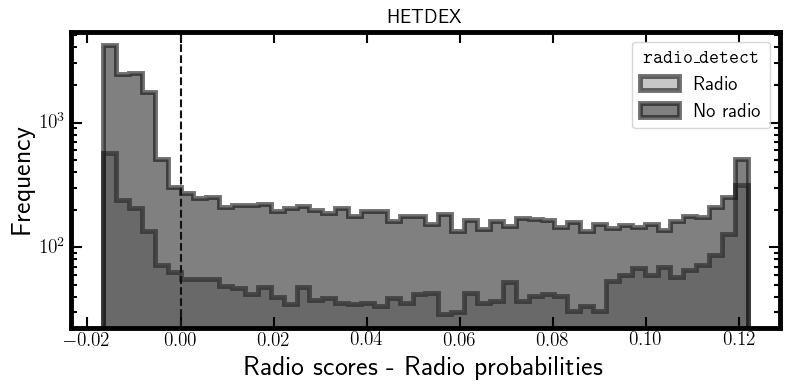

In [144]:
fig             = plt.figure(figsize=(8,4))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

filt_tmp_radio  = np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

plt.hist((full_catalog_df.loc[filt_tmp_radio, 'Score_radio'] - full_catalog_df.loc[filt_tmp_radio, 'Prob_radio']),\
         histtype='stepfilled', fc=plt.get_cmap(gv.cmap_conf_matr)(0.3), ec='k', bins=50, lw=3.5, alpha=0.6, label='Radio')
plt.hist((full_catalog_df.loc[~filt_tmp_radio, 'Score_radio'] - full_catalog_df.loc[~filt_tmp_radio, 'Prob_radio']),\
         histtype='stepfilled', fc=plt.get_cmap(gv.cmap_conf_matr)(0.8), ec='k', bins=50, lw=3.5, alpha=0.6, label='No radio')
plt.axvline(x=0.0, color='k', ls='dashed')
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio scores - Radio probabilities', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_detect}$', title_fontsize=14)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

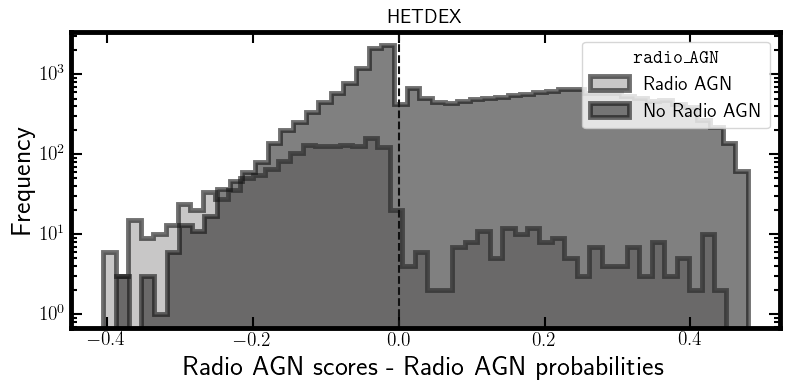

In [145]:
fig             = plt.figure(figsize=(8,4))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

filt_tmp_rAGN    = np.array(full_catalog_df.loc[:, 'radio_AGN'] == 1)

plt.hist((full_catalog_df.loc[filt_tmp_rAGN, 'Score_rAGN'] - full_catalog_df.loc[filt_tmp_rAGN, 'Prob_rAGN']),\
         histtype='stepfilled', fc=plt.get_cmap(gv.cmap_conf_matr)(0.3), ec='k', bins=50, lw=3.5, alpha=0.6, label='Radio AGN')
plt.hist((full_catalog_df.loc[~filt_tmp_rAGN, 'Score_rAGN'] - full_catalog_df.loc[~filt_tmp_rAGN, 'Prob_rAGN']),\
         histtype='stepfilled', fc=plt.get_cmap(gv.cmap_conf_matr)(0.8), ec='k', bins=50, lw=3.5, alpha=0.6, label='No Radio AGN')
plt.axvline(x=0.0, color='k', ls='dashed')
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN scores - Radio AGN probabilities', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_AGN}$', title_fontsize=14)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

---

## Additional test with data from Ananna et al., 2017

In [146]:
if compare_A17_flag:
    full_catalog_A17_df = pd.read_hdf(gv.cat_path + gv.file_S82_Ananna_17, key='df').drop(columns=features_2_discard)

In [147]:
if compare_A17_flag:
    full_catalog_A17_df = pyr.predict_model(redshift_reg, data=full_catalog_A17_df, round=8)
    full_catalog_A17_df = full_catalog_A17_df.rename(columns={'Label': 'pred_Z', 'is_AGN': 'class'})
    full_catalog_A17_df['pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    redshift_tol    = 0.0
    if use_second_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_2, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)

In [148]:
if compare_A17_flag:
    sigma_mad_AGN_A17            = gf.sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_AGN_A17           = gf.sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_AGN_A17              = gf.sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_AGN_A17         = gf.sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_AGN_A17             = gf.outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [149]:
if compare_A17_flag:
    size_AGN_A17         = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']) & np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    metrics_z_AGN_A17    = np.array([size_AGN_A17, sigma_mad_AGN_A17, sigma_nmad_AGN_A17, sigma_z_AGN_A17,
                                     sigma_z_norm_AGN_A17, out_frac_AGN_A17])
    metrics_z_A17_df = pd.DataFrame(columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])
    metrics_z_A17_df.loc['AGN'] = metrics_z_AGN_A17

In [150]:
if compare_A17_flag:
    fig              = plt.figure(figsize=(7.5,4.3))
    ax1              = fig.add_subplot(111, xscale='linear', yscale='linear')
    
    min_score        = np.nanmin([np.nanmin(full_catalog_A17_df.loc[:, 'zsp']), np.nanmin(full_catalog_A17_df.loc[:, 'pred_Z'])])
    max_score        = np.nanmax([np.nanmax(full_catalog_A17_df.loc[:, 'zsp']), np.nanmax(full_catalog_A17_df.loc[:, 'pred_Z'])])
    score_bins       = np.linspace(min_score, max_score, 30)
    
    sample_size_orig = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']))
    sample_size_pred = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    
    ax1.hist(full_catalog_A17_df.loc[:, 'zsp'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.8,\
             label=f'Original\nN={sample_size_orig:,}', zorder=2)
    ax1.hist(full_catalog_A17_df.loc[:, 'pred_Z'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
             label=f'Predicted\nN={sample_size_pred:,}', zorder=1)
        
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax1.set_xlabel('Redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=14)
    plt.grid(False)
    ax1.set_title('S82: Ananna+17')
    #ax1.set_aspect('equal', 'box')
    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'hist_redshift_AGN_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()

In [151]:
if compare_A17_flag:
    full_catalog_A17_df = full_catalog_A17_df.loc[np.array(full_catalog_A17_df.loc[:, 'class'] == 1) &\
                                                  np.array(full_catalog_A17_df.loc[:, 'VLAS82_detect'] == 1)]

In [152]:
if compare_A17_flag:
    used_z_col = 'zsp'
    full_catalog_A17_df['Delta_z_N'] = np.around((full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                 (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)
    full_catalog_A17_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                  (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)

In [153]:
if compare_A17_flag:
    show_columns_A17 = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'band_num', 'Z', 'zsp', 'pred_Z', 'Delta_z_N']
    with pd.option_context('display.float_format', '{:.4f}'.format):
        display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by='pred_Z', ascending=False).head(10))
        display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by=used_z_col, ascending=False).head(10))

In [154]:
if compare_A17_flag:
    sigma_mad_rAGN_A17            = gf.sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_rAGN_A17           = gf.sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_rAGN_A17              = gf.sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_rAGN_A17         = gf.sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_rAGN_A17             = gf.outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [155]:
if compare_A17_flag:
    size_rAGN_A17     = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']) & np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    metrics_z_rAGN_A17    = np.array([size_rAGN_A17, sigma_mad_rAGN_A17, sigma_nmad_rAGN_A17, sigma_z_rAGN_A17,
                                 sigma_z_norm_rAGN_A17, out_frac_rAGN_A17])
    metrics_z_A17_df.loc['Radio AGN'] = metrics_z_rAGN_A17

In [156]:
if compare_A17_flag:
    print('Metrics for redshift predictions in all AGN and Radio AGN from Ananna et al., 2017 with counterparts in our sample')
    metrics_z_A17_df.loc[:, 'Sample'] = metrics_z_A17_df.loc[:, 'Sample'].astype(int)
    with pd.option_context('display.float_format', '{:.4f}'.format):
        display(metrics_z_A17_df)

In [157]:
if compare_A17_flag:
    fig             = plt.figure(figsize=(6,5))
    ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
    _ = gf.plot_redshift_compare(full_catalog_A17_df.loc[:, used_z_col], full_catalog_A17_df.loc[:, 'pred_Z'],\
                          ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'compare_redshift_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()

---

## Additional metrics for the known $z \geq 4$ AGN in HETDEX.

In [158]:
if metrics_hiz_AGN:
    cm_AGN_hiz_HETDEX   = gf.conf_mat_func(hiz_catalog_df.loc[:, 'class'],        hiz_catalog_df.loc[:, 'pred_class_cal'])
    cm_radio_hiz_HETDEX = gf.conf_mat_func(hiz_catalog_df.loc[:, 'LOFAR_detect'], hiz_catalog_df.loc[:, 'pred_radio_cal'])
    cm_rAGN_hiz_HETDEX  = gf.conf_mat_func(hiz_catalog_df.loc[:, 'radio_AGN'],    hiz_catalog_df.loc[:, 'pred_prob_rAGN'])

In [159]:
if metrics_hiz_AGN:
    print('Confusion matrix for AGN-galaxy classification')
    display(cm_AGN_hiz_HETDEX)
    print('Confusion matrix for Radio detection prediction')
    display(cm_radio_hiz_HETDEX)
    print('Confusion matrix for Radio AGN detection prediction')
    display(cm_rAGN_hiz_HETDEX)

Confusion matrix for AGN-galaxy classification


array([[  0,   0],
       [  7, 114]])

Confusion matrix for Radio detection prediction


array([[64, 26],
       [12, 19]])

Confusion matrix for Radio AGN detection prediction


array([[66, 24],
       [13, 18]])

In [160]:
if metrics_hiz_AGN:
    MCC_AGN_hiz_HETDEX             = gf.MCC_from_CM(cm_AGN_hiz_HETDEX)
    ACC_AGN_hiz_HETDEX             = gf.ACC_from_CM(cm_AGN_hiz_HETDEX)
    Fb_AGN_hiz_HETDEX              = gf.Fb_from_CM(cm_AGN_hiz_HETDEX)
    Precision_AGN_hiz_HETDEX       = gf.Precision_from_CM(cm_AGN_hiz_HETDEX)
    Recall_AGN_hiz_HETDEX          = gf.Recall_from_CM(cm_AGN_hiz_HETDEX)
    
    MCC_radio_hiz_HETDEX           = gf.MCC_from_CM(cm_radio_hiz_HETDEX)
    ACC_radio_hiz_HETDEX           = gf.ACC_from_CM(cm_radio_hiz_HETDEX)
    Fb_radio_hiz_HETDEX            = gf.Fb_from_CM(cm_radio_hiz_HETDEX)
    Precision_radio_hiz_HETDEX     = gf.Precision_from_CM(cm_radio_hiz_HETDEX)
    Recall_radio_hiz_HETDEX        = gf.Recall_from_CM(cm_radio_hiz_HETDEX)
    
    MCC_radio_AGN_hiz_HETDEX       = gf.MCC_from_CM(cm_rAGN_hiz_HETDEX)
    ACC_radio_AGN_hiz_HETDEX       = gf.ACC_from_CM(cm_rAGN_hiz_HETDEX)
    Fb_radio_AGN_hiz_HETDEX        = gf.Fb_from_CM(cm_rAGN_hiz_HETDEX)
    Precision_radio_AGN_hiz_HETDEX = gf.Precision_from_CM(cm_rAGN_hiz_HETDEX)
    Recall_radio_AGN_hiz_HETDEX    = gf.Recall_from_CM(cm_rAGN_hiz_HETDEX)

In [161]:
if metrics_hiz_AGN:
    sigma_mad_hiz_HETDEX    = gf.sigma_mad(hiz_catalog_df.loc[:, 'Z'],    hiz_catalog_df.loc[:, 'pred_Z'])
    sigma_nmad_hiz_HETDEX   = gf.sigma_nmad(hiz_catalog_df.loc[:, 'Z'],   hiz_catalog_df.loc[:, 'pred_Z'])
    sigma_z_hiz_HETDEX      = gf.sigma_z(hiz_catalog_df.loc[:, 'Z'],      hiz_catalog_df.loc[:, 'pred_Z'])
    sigma_z_norm_hiz_HETDEX = gf.sigma_z_norm(hiz_catalog_df.loc[:, 'Z'], hiz_catalog_df.loc[:, 'pred_Z'])
    out_frac_hiz_HETDEX     = gf.outlier_frac(hiz_catalog_df.loc[:, 'Z'], hiz_catalog_df.loc[:, 'pred_Z'])

In [162]:
if metrics_hiz_AGN:
    metrics_classif_hiz_HETDEX   = np.array([[np.sum(filter_hiz_HETDEX),      Fb_AGN_hiz_HETDEX,       
                                              MCC_AGN_hiz_HETDEX,       Precision_AGN_hiz_HETDEX,       
                                              Recall_AGN_hiz_HETDEX,       ACC_AGN_hiz_HETDEX],\
                                             [np.sum(filter_hiz_HETDEX),      Fb_radio_hiz_HETDEX,     
                                              MCC_radio_hiz_HETDEX,     Precision_radio_hiz_HETDEX,     
                                              Recall_radio_hiz_HETDEX,     ACC_radio_hiz_HETDEX],\
                                             [np.sum(filter_hiz_HETDEX),      Fb_radio_AGN_hiz_HETDEX, 
                                              MCC_radio_AGN_hiz_HETDEX, Precision_radio_AGN_hiz_HETDEX, 
                                              Recall_radio_AGN_hiz_HETDEX, ACC_radio_AGN_hiz_HETDEX]])
    metrics_classif_hiz_HETDEX_df   = pd.DataFrame(data=metrics_classif_hiz_HETDEX, 
                                                   columns=['Sample', 'F-\u03B2', 'MCC', 'Precision', 'Recall', 'Accuracy'],
                                                   index=['AGN/Galaxy', 'Radio', 'Radio AGN'])

In [163]:
if metrics_hiz_AGN:
    size_rAGN_hiz_HETDEX    = np.sum(filter_hiz_HETDEX)
    metrics_z_hiz_HETDEX    = np.array([[size_rAGN_hiz_HETDEX, sigma_mad_hiz_HETDEX,
                                         sigma_nmad_hiz_HETDEX, sigma_z_hiz_HETDEX,
                                         sigma_z_norm_hiz_HETDEX, out_frac_hiz_HETDEX]])
    metrics_z_hiz_HETDEX_df = pd.DataFrame(data=metrics_z_hiz_HETDEX,\
                                columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'],\
                                index=['Redshift prediction'])

In [164]:
if metrics_hiz_AGN:
    print('Metrics for classification using steps from\npipeline using probabilities in high-z HETDEX AGN.')
    metrics_classif_hiz_HETDEX_df.loc[:, 'Sample'] = metrics_classif_hiz_HETDEX_df.loc[:, 'Sample'].astype(int)
    with pd.option_context('display.float_format', '{:.4f}'.format):
        display(metrics_classif_hiz_HETDEX_df.drop(columns=['Accuracy']))

Metrics for classification using steps from
pipeline using probabilities in high-z HETDEX AGN.


,Sample,F-β,MCC,Precision,Recall
AGN/Galaxy,121,0.9675,NaN,1.0000,0.9421
Radio,121,0.5089,0.2927,0.4222,0.6129
Radio AGN,121,0.5003,0.2879,0.4286,0.5806


In [165]:
if metrics_hiz_AGN:
    print('Metrics for redshift predictions for high-z HETDEX AGN')
    metrics_z_hiz_HETDEX_df.loc[:, 'Sample'] = metrics_z_hiz_HETDEX_df.loc[:, 'Sample'].astype(int)
    with pd.option_context('display.float_format', '{:.4f}'.format):
        display(metrics_z_hiz_HETDEX_df)

Metrics for redshift predictions for high-z HETDEX AGN


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
Redshift prediction,121,0.3968,0.0703,1.4653,0.2327,0.2893
